In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=20,10
import seaborn as sns
sns.set(color_codes=True)
import sys
import os
import sagemaker     
import s3fs
import boto3
import re
import io
import sagemaker.amazon.common as smac
import pathlib

In [2]:
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket = sagemaker.Session().default_bucket()
prefix = (
    "sagemaker/solar_suitability_prediction"  
)

# Reading datset

In [3]:
bucket='datascience-nurture/ManchesterData/epc_all-domestic-certificates_Manchester.csv'
data_key='MasterDataset_Manchester.csv'
data_location='s3://datascience-nurture/ManchesterData/epc_all-domestic-certificates_Manchester.csv'.format(bucket, data_key)
df=pd.read_csv(data_location)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,LMK_KEY,ADDRESS1,ADDRESS2,ADDRESS3,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,...,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,UPRN_SOURCE,postcodes_district
0,1801923532602020060916133774000918,"703, Burnage Lane",NaN,NaN,M19 1RR,1660830778,D,B,60,82,...,Stockport,MANCHESTER,England and Wales: 1950-1966,2020-06-09 16:13:37,rental (private),NaN,NaN,100011464065,Address Matched,M19
1,726445359202011112214550895392098,"44, Tytherington Drive",NaN,NaN,M19 3TD,9223453968,D,D,55,64,...,Denton and Reddish,MANCHESTER,England and Wales: 1991-1995,2011-11-22 14:55:08,rental (private),9.0,0.0,200000779332,Address Matched,M19
2,1163502589342014062520061726442158,"5, Simon Freeman Close",NaN,NaN,M19 2WE,3381984278,C,B,74,84,...,Stockport,MANCHESTER,England and Wales: 1976-1982,2014-06-25 20:06:17,rental (private),17.0,10.0,100011520675,Address Matched,M19
3,827231399262012082107081741408732,"534, Nelstrop Road",NaN,NaN,M19 3JL,3455901078,D,B,68,86,...,Denton and Reddish,MANCHESTER,England and Wales: 1930-1949,2012-08-21 07:08:17,rental (private),8.0,4.0,200000779284,Address Matched,M19
4,1795427782042020032616292861902368,"677a, Burnage Lane",NaN,NaN,M19 1RR,7065889678,B,A,82,93,...,Stockport,MANCHESTER,NO DATA!,2020-03-26 16:29:28,unknown,10.0,10.0,10094502334,Address Matched,M19


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537922 entries, 0 to 537921
Data columns (total 93 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   LMK_KEY                        537922 non-null  object 
 1   ADDRESS1                       537921 non-null  object 
 2   ADDRESS2                       340058 non-null  object 
 3   ADDRESS3                       40088 non-null   object 
 4   POSTCODE                       537922 non-null  object 
 5   BUILDING_REFERENCE_NUMBER      537922 non-null  int64  
 6   CURRENT_ENERGY_RATING          537922 non-null  object 
 7   POTENTIAL_ENERGY_RATING        537922 non-null  object 
 8   CURRENT_ENERGY_EFFICIENCY      537922 non-null  int64  
 9   POTENTIAL_ENERGY_EFFICIENCY    537922 non-null  int64  
 10  PROPERTY_TYPE                  537922 non-null  object 
 11  BUILT_FORM                     537579 non-null  object 
 12  INSPECTION_DATE               

In [6]:
df.describe()

,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,CO2_EMISSIONS_POTENTIAL,...,NUMBER_OPEN_FIREPLACES,SHEATING_ENERGY_EFF,SHEATING_ENV_EFF,WIND_TURBINE_COUNT,UNHEATED_CORRIDOR_LENGTH,FLOOR_HEIGHT,PHOTO_SUPPLY,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN
count,5.379220e+05,537922.000000,537922.000000,537922.000000,537922.000000,537922.000000,537922.000000,537922.000000,537922.000000,537922.000000,...,526791.000000,0.0,0.0,494834.000000,91043.000000,213789.000000,296058.000000,247700.000000,221567.000000,5.379220e+05
mean,5.427984e+09,65.748553,78.732169,63.732353,76.861679,252.739849,161.703824,3.448702,44.277958,2.119151,...,0.052734,NaN,NaN,0.000063,6.444317,2.499568,0.225169,9.927606,5.829537,4.539710e+10
std,3.096964e+09,13.047672,8.984661,14.913529,11.034313,123.816356,97.651254,2.380642,21.539375,1.486960,...,0.334507,NaN,NaN,0.032820,3.563805,0.313032,3.232228,5.642581,5.166673,6.597411e+10
min,7.400000e+01,1.000000,1.000000,1.000000,1.000000,-930.000000,-948.000000,-2.300000,-169.000000,-2.400000,...,0.000000,NaN,NaN,-1.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000e+00
25%,2.730262e+09,59.000000,75.000000,54.000000,71.000000,180.000000,99.000000,2.000000,32.000000,1.300000,...,0.000000,NaN,NaN,0.000000,4.260000,2.380000,0.000000,7.000000,2.000000,7.710852e+07
50%,5.475299e+09,68.000000,80.000000,66.000000,79.000000,233.000000,143.000000,2.900000,41.000000,1.800000,...,0.000000,NaN,NaN,0.000000,6.130000,2.430000,0.000000,9.000000,5.000000,1.007039e+10
75%,8.203439e+09,75.000000,85.000000,74.000000,84.000000,303.000000,203.000000,4.300000,54.000000,2.600000,...,0.000000,NaN,NaN,0.000000,8.240000,2.600000,0.000000,11.000000,8.000000,1.000114e+11
max,1.000170e+10,147.000000,148.000000,156.000000,157.000000,19080.000000,18601.000000,170.000000,3696.000000,166.000000,...,70.000000,NaN,NaN,2.000000,100.000000,27.900000,100.000000,621.000000,300.000000,5.801031e+11


In [7]:
df.shape

(537922, 93)

In [8]:
df.columns

Index(['LMK_KEY', 'ADDRESS1', 'ADDRESS2', 'ADDRESS3', 'POSTCODE',
       'BUILDING_REFERENCE_NUMBER', 'CURRENT_ENERGY_RATING',
       'POTENTIAL_ENERGY_RATING', 'CURRENT_ENERGY_EFFICIENCY',
       'POTENTIAL_ENERGY_EFFICIENCY', 'PROPERTY_TYPE', 'BUILT_FORM',
       'INSPECTION_DATE', 'LOCAL_AUTHORITY', 'CONSTITUENCY', 'COUNTY',
       'LODGEMENT_DATE', 'TRANSACTION_TYPE', 'ENVIRONMENT_IMPACT_CURRENT',
       'ENVIRONMENT_IMPACT_POTENTIAL', 'ENERGY_CONSUMPTION_CURRENT',
       'ENERGY_CONSUMPTION_POTENTIAL', 'CO2_EMISSIONS_CURRENT',
       'CO2_EMISS_CURR_PER_FLOOR_AREA', 'CO2_EMISSIONS_POTENTIAL',
       'LIGHTING_COST_CURRENT', 'LIGHTING_COST_POTENTIAL',
       'HEATING_COST_CURRENT', 'HEATING_COST_POTENTIAL',
       'HOT_WATER_COST_CURRENT', 'HOT_WATER_COST_POTENTIAL',
       'TOTAL_FLOOR_AREA', 'ENERGY_TARIFF', 'MAINS_GAS_FLAG', 'FLOOR_LEVEL',
       'FLAT_TOP_STOREY', 'FLAT_STOREY_COUNT', 'MAIN_HEATING_CONTROLS',
       'MULTI_GLAZE_PROPORTION', 'GLAZED_TYPE', 'GLAZED_AREA',
      

# cleaning dataset

In [9]:
df.isnull().sum()

LMK_KEY                              0
ADDRESS1                             1
ADDRESS2                        197864
ADDRESS3                        497834
POSTCODE                             0
                                 ...  
FIXED_LIGHTING_OUTLETS_COUNT    290222
LOW_ENERGY_FIXED_LIGHT_COUNT    316355
UPRN                                 0
UPRN_SOURCE                      33786
postcodes_district                   0
Length: 93, dtype: int64

In [10]:
df.drop(['ADDRESS2','ADDRESS3','UPRN_SOURCE','SHEATING_ENERGY_EFF', 'SHEATING_ENV_EFF','ADDRESS'],axis=1,inplace=True)

In [11]:
df.fillna(0)

,LMK_KEY,ADDRESS1,POSTCODE,BUILDING_REFERENCE_NUMBER,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,...,LOCAL_AUTHORITY_LABEL,CONSTITUENCY_LABEL,POSTTOWN,CONSTRUCTION_AGE_BAND,LODGEMENT_DATETIME,TENURE,FIXED_LIGHTING_OUTLETS_COUNT,LOW_ENERGY_FIXED_LIGHT_COUNT,UPRN,postcodes_district
0,1801923532602020060916133774000918,"703, Burnage Lane",M19 1RR,1660830778,D,B,60,82,House,Semi-Detached,...,Stockport,Stockport,MANCHESTER,England and Wales: 1950-1966,2020-06-09 16:13:37,rental (private),0.0,0.0,100011464065,M19
1,726445359202011112214550895392098,"44, Tytherington Drive",M19 3TD,9223453968,D,D,55,64,House,Semi-Detached,...,Stockport,Denton and Reddish,MANCHESTER,England and Wales: 1991-1995,2011-11-22 14:55:08,rental (private),9.0,0.0,200000779332,M19
2,1163502589342014062520061726442158,"5, Simon Freeman Close",M19 2WE,3381984278,C,B,74,84,House,Semi-Detached,...,Stockport,Stockport,MANCHESTER,England and Wales: 1976-1982,2014-06-25 20:06:17,rental (private),17.0,10.0,100011520675,M19
3,827231399262012082107081741408732,"534, Nelstrop Road",M19 3JL,3455901078,D,B,68,86,House,Semi-Detached,...,Stockport,Denton and Reddish,MANCHESTER,England and Wales: 1930-1949,2012-08-21 07:08:17,rental (private),8.0,4.0,200000779284,M19
4,1795427782042020032616292861902368,"677a, Burnage Lane",M19 1RR,7065889678,B,A,82,93,House,Detached,...,Stockport,Stockport,MANCHESTER,NO DATA!,2020-03-26 16:29:28,unknown,10.0,10.0,10094502334,M19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537917,bacbaf75f224db6f7860db6eb98a7223df358036cbf262...,6 Weaver Chase,M26 1RF,10001543054,C,B,78,88,House,Semi-Detached,...,Bolton,Bolton South East,MANCHESTER,England and Wales: 2003-2006,2021-09-20 13:27:42,Owner-occupied,12.0,0.0,10013867574,M26
537918,0c3854d7fb1daf7cab9a21ab965cde292bb416c37344d9...,11 Churchbeck Chase,M26 1RG,10001339685,C,B,70,81,Flat,Semi-Detached,...,Bolton,Bolton South East,MANCHESTER,England and Wales: 2003-2006,2021-09-30 18:37:18,Owner-occupied,3.0,0.0,10013867534,M26
537919,22fd395ced83afb5f2319be9f4818a667bad86ce25a255...,27 Lock View,M26 1QH,10001442658,C,B,75,84,Flat,Mid-Terrace,...,Bolton,Bolton South East,MANCHESTER,England and Wales: 2003-2006,2021-09-19 06:40:17,Rented (private),6.0,0.0,10001245678,M26
537920,f58e3e1e5ddcad74b4c6d040ecbd307981aeccfa120091...,88 MARKET STREET,M26 1HB,10001582212,C,B,69,86,House,Mid-Terrace,...,Bolton,Bolton South East,MANCHESTER,England and Wales: 1900-1929,2021-07-30 12:52:22,Owner-occupied,8.0,0.0,100012689859,M26


In [12]:
#pip install pandas_profiling

In [13]:
#import pandas_profiling as pp
#pp.ProfileReport(df)

In [14]:
df.duplicated().sum()

0

# Exploratory data analysis

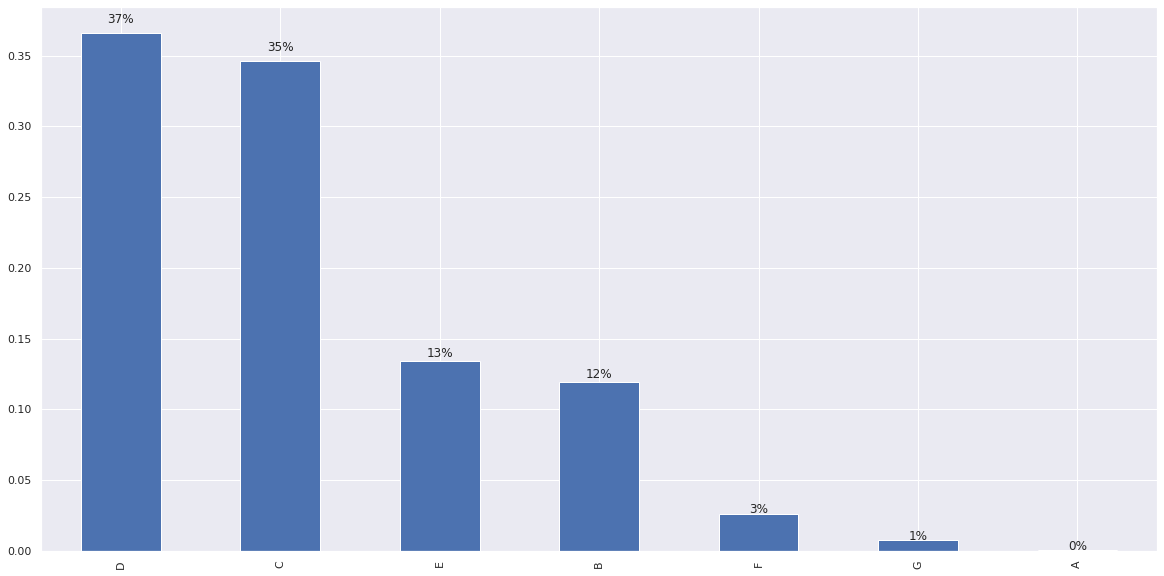

In [15]:
#energy rating of properties

cer=df.CURRENT_ENERGY_RATING.value_counts(normalize=True).plot.bar()
for p in cer.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    cer.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center')

<AxesSubplot:>

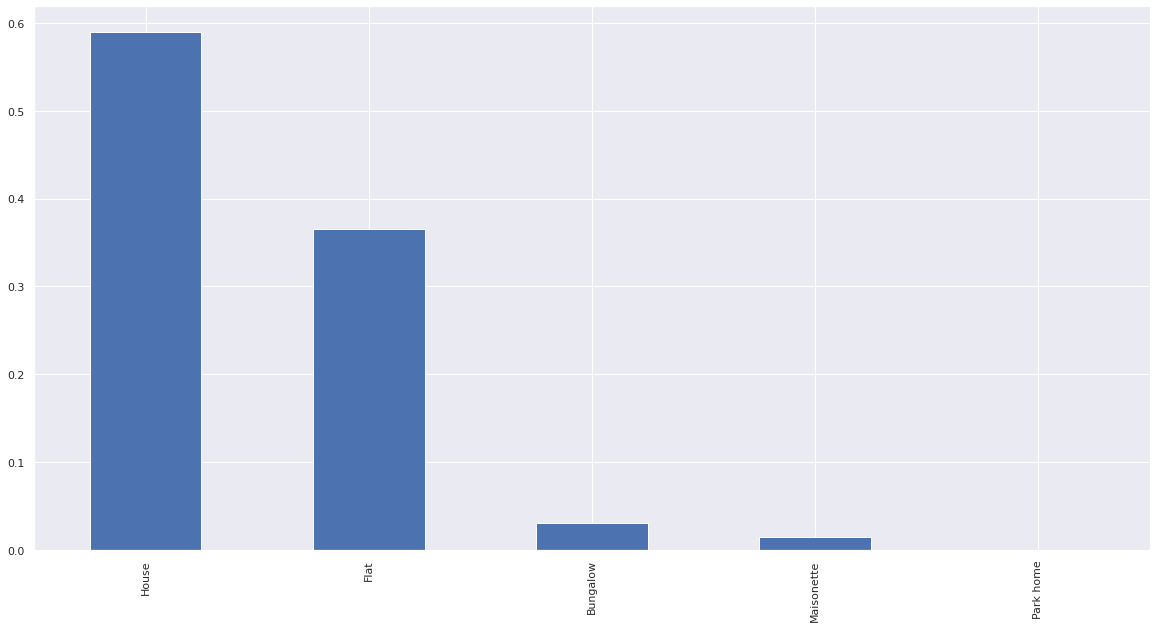

In [16]:
#property type count

df.PROPERTY_TYPE.value_counts(normalize=True).plot.bar()

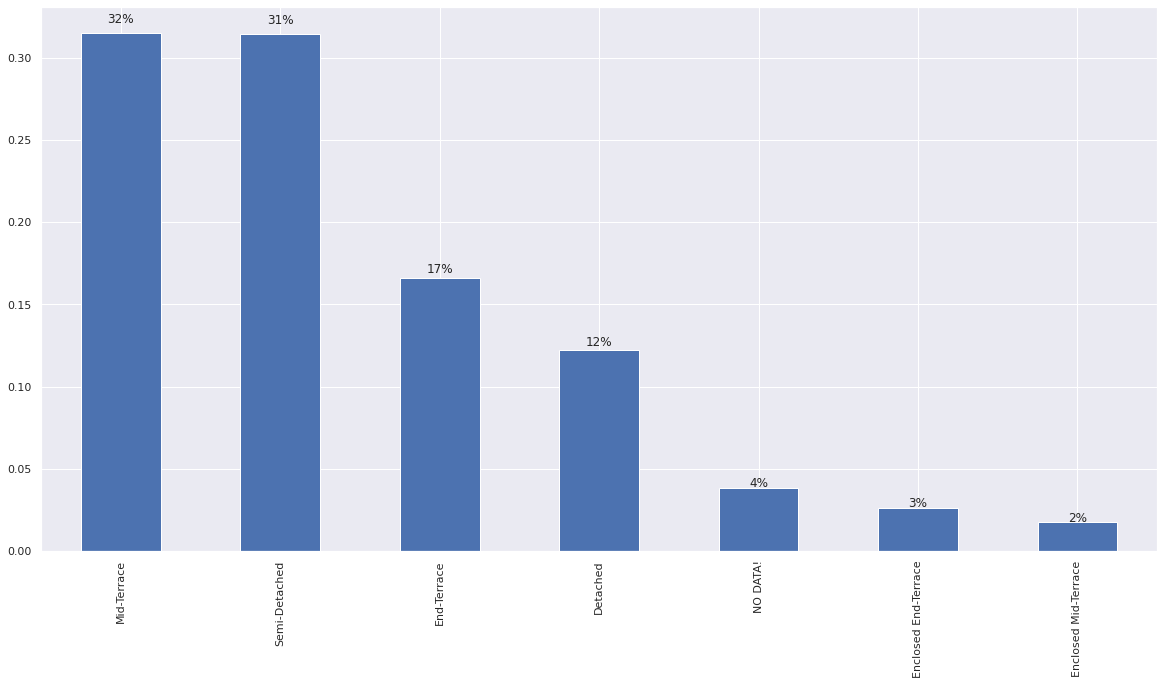

In [17]:
#property built form

ax=df.BUILT_FORM.value_counts(normalize=True).plot.bar()
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center')

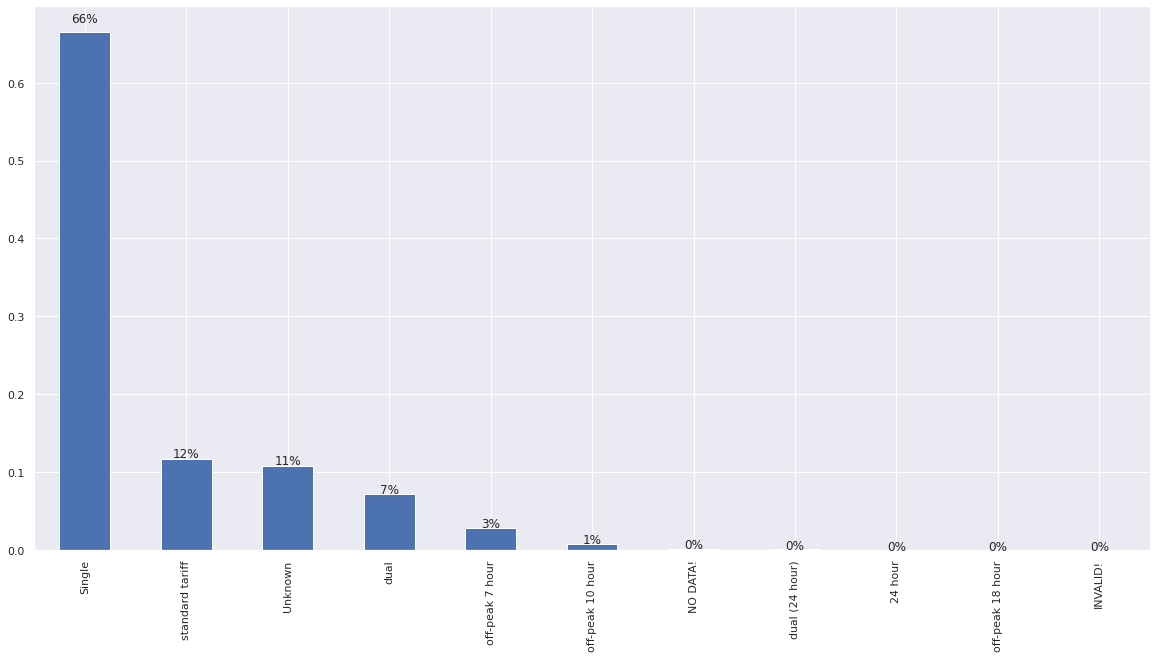

In [18]:
ax=df.ENERGY_TARIFF.value_counts(normalize=True).plot.bar()
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center')

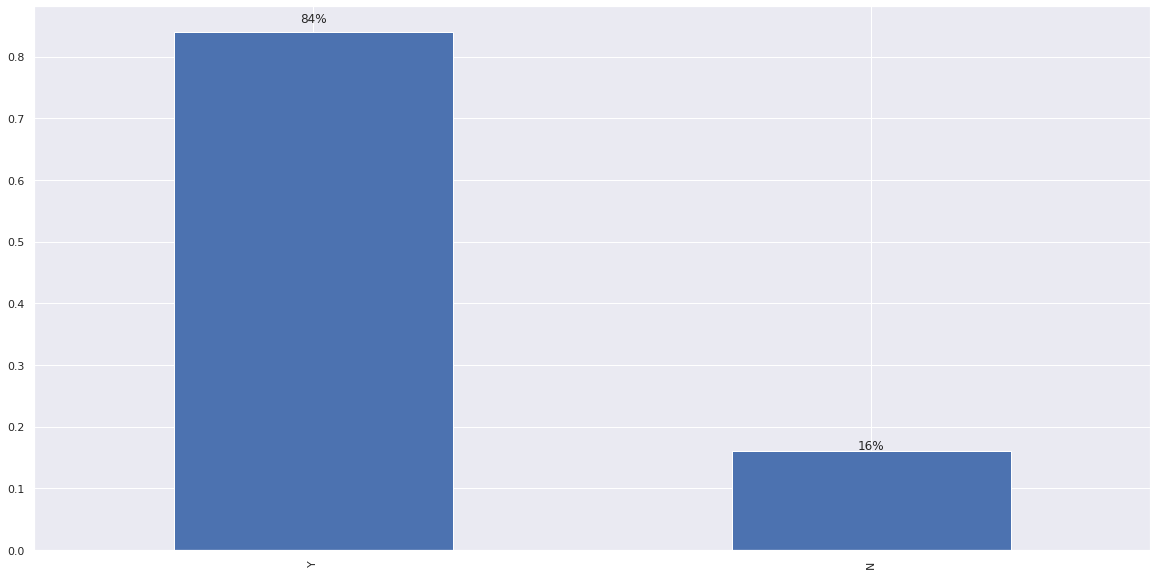

In [19]:
ax=df.MAINS_GAS_FLAG.value_counts(normalize=True).plot.bar()
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.02), ha='center')

<AxesSubplot:>

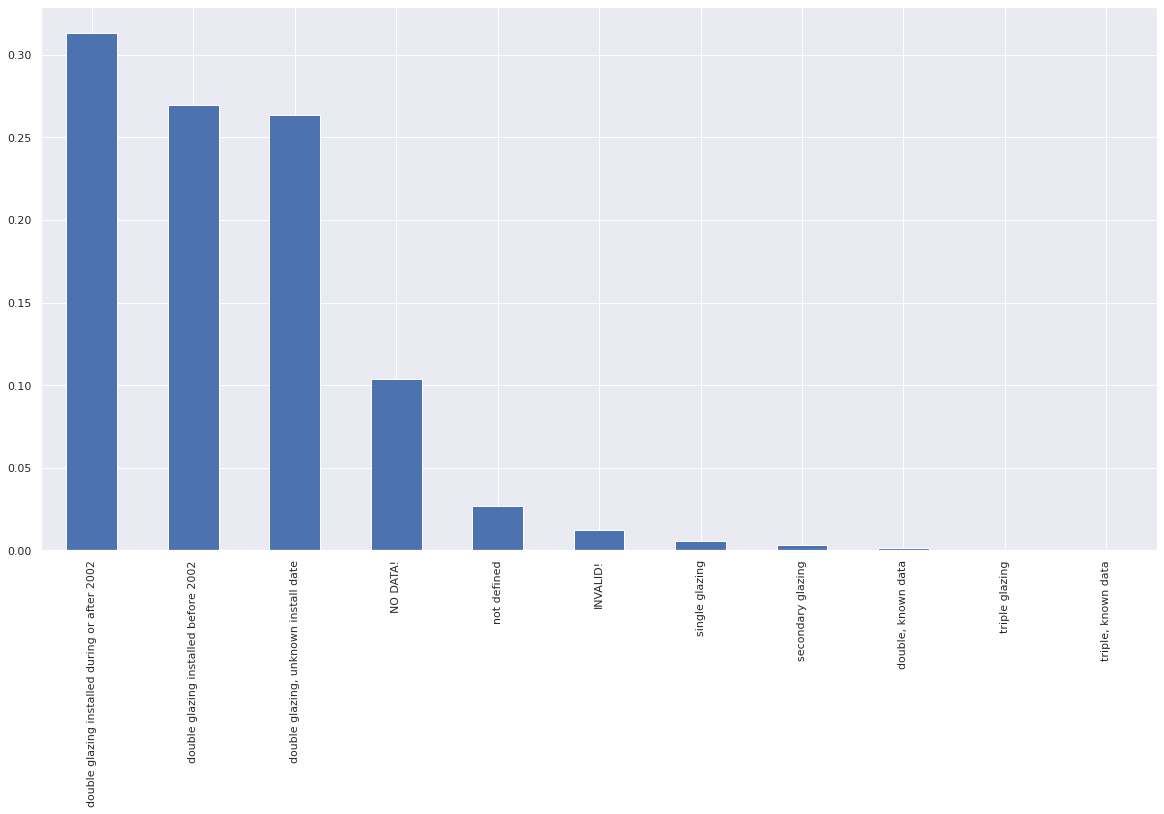

In [20]:
#Glazed type in properties
df.GLAZED_TYPE.value_counts(normalize=True).plot.bar()

In [21]:
df.WIND_TURBINE_COUNT.value_counts(normalize=True)

 0.0    0.998929
 1.0    0.000564
-1.0    0.000505
 2.0    0.000002
Name: WIND_TURBINE_COUNT, dtype: float64

In [22]:
df.SOLAR_WATER_HEATING_FLAG.value_counts(normalize=True)

N    0.996379
Y    0.003621
Name: SOLAR_WATER_HEATING_FLAG, dtype: float64

In [23]:
my_data=df[['CURRENT_ENERGY_RATING',
       'POTENTIAL_ENERGY_RATING', 'CURRENT_ENERGY_EFFICIENCY',
       'POTENTIAL_ENERGY_EFFICIENCY', 'PROPERTY_TYPE', 'BUILT_FORM',
       'INSPECTION_DATE','LODGEMENT_DATE', 'TRANSACTION_TYPE', 'ENVIRONMENT_IMPACT_CURRENT',
       'ENVIRONMENT_IMPACT_POTENTIAL', 'ENERGY_CONSUMPTION_CURRENT',
       'ENERGY_CONSUMPTION_POTENTIAL', 'CO2_EMISSIONS_CURRENT',
       'CO2_EMISS_CURR_PER_FLOOR_AREA', 'CO2_EMISSIONS_POTENTIAL',
       'LIGHTING_COST_CURRENT', 'LIGHTING_COST_POTENTIAL',
       'HEATING_COST_CURRENT', 'HEATING_COST_POTENTIAL',
       'HOT_WATER_COST_CURRENT', 'HOT_WATER_COST_POTENTIAL',
       'TOTAL_FLOOR_AREA', 'ENERGY_TARIFF', 'MAINS_GAS_FLAG', 'FLOOR_LEVEL',
        'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS',
       'LOW_ENERGY_LIGHTING', 'NUMBER_OPEN_FIREPLACES','PHOTO_SUPPLY', 'SOLAR_WATER_HEATING_FLAG','UPRN','ROOF_DESCRIPTION']]

In [24]:
my_data.head()

,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,INSPECTION_DATE,LODGEMENT_DATE,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,...,MAINS_GAS_FLAG,FLOOR_LEVEL,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,PHOTO_SUPPLY,SOLAR_WATER_HEATING_FLAG,UPRN,ROOF_DESCRIPTION
0,D,B,60,82,House,Semi-Detached,2020-06-09,2020-06-09,rental (private),51,...,Y,NODATA!,6.0,6.0,40.0,0.0,NaN,N,100011464065,"Pitched, no insulation"
1,D,D,55,64,House,Semi-Detached,2011-11-21,2011-11-22,rental (private),52,...,Y,NODATA!,4.0,4.0,0.0,0.0,0.0,NaN,200000779332,"Pitched, 150 mm loft insulation"
2,C,B,74,84,House,Semi-Detached,2014-06-25,2014-06-25,rental (private),73,...,Y,NODATA!,7.0,7.0,59.0,0.0,0.0,NaN,100011520675,"Pitched, 250mm loft insulation"
3,D,B,68,86,House,Semi-Detached,2012-08-20,2012-08-21,rental (private),69,...,Y,NODATA!,3.0,3.0,50.0,0.0,0.0,NaN,200000779284,"Pitched, 150 mm loft insulation"
4,B,A,82,93,House,Detached,2020-03-26,2020-03-26,new dwelling,83,...,NaN,NO DATA!,NaN,NaN,100.0,0.0,NaN,NaN,10094502334,Average thermal transmittance 0.11 W/m²K


In [25]:
my_data.tail()

,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,INSPECTION_DATE,LODGEMENT_DATE,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,...,MAINS_GAS_FLAG,FLOOR_LEVEL,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,PHOTO_SUPPLY,SOLAR_WATER_HEATING_FLAG,UPRN,ROOF_DESCRIPTION
537917,C,B,78,88,House,Semi-Detached,2021-09-20,2021-09-20,marketed sale,77,...,Y,NaN,7.0,7.0,75.0,0.0,0.0,N,10013867574,"Pitched, 300 mm loft insulation"
537918,C,B,70,81,Flat,Semi-Detached,2021-09-27,2021-09-30,marketed sale,67,...,N,02,3.0,3.0,100.0,0.0,0.0,N,10013867534,"Pitched, insulated (assumed)"
537919,C,B,75,84,Flat,Mid-Terrace,2021-09-17,2021-09-19,rental,74,...,N,02,2.0,2.0,100.0,0.0,0.0,N,10001245678,"Pitched, 270 mm loft insulation"
537920,C,B,69,86,House,Mid-Terrace,2021-07-30,2021-07-30,marketed sale,65,...,Y,NaN,5.0,5.0,88.0,0.0,0.0,N,100012689859,"Pitched, 100 mm loft insulation"
537921,B,B,82,87,Flat,Mid-Terrace,2021-07-31,2021-08-03,marketed sale,79,...,N,01,3.0,3.0,100.0,0.0,0.0,N,10001245683,(another dwelling above)


In [26]:
my_data.isnull().sum()

CURRENT_ENERGY_RATING                 0
POTENTIAL_ENERGY_RATING               0
CURRENT_ENERGY_EFFICIENCY             0
POTENTIAL_ENERGY_EFFICIENCY           0
PROPERTY_TYPE                         0
BUILT_FORM                          343
INSPECTION_DATE                       0
LODGEMENT_DATE                        0
TRANSACTION_TYPE                      0
ENVIRONMENT_IMPACT_CURRENT            0
ENVIRONMENT_IMPACT_POTENTIAL          0
ENERGY_CONSUMPTION_CURRENT            0
ENERGY_CONSUMPTION_POTENTIAL          0
CO2_EMISSIONS_CURRENT                 0
CO2_EMISS_CURR_PER_FLOOR_AREA         0
CO2_EMISSIONS_POTENTIAL               0
LIGHTING_COST_CURRENT                 0
LIGHTING_COST_POTENTIAL               0
HEATING_COST_CURRENT                  0
HEATING_COST_POTENTIAL                0
HOT_WATER_COST_CURRENT                0
HOT_WATER_COST_POTENTIAL              0
TOTAL_FLOOR_AREA                      0
ENERGY_TARIFF                        11
MAINS_GAS_FLAG                    69629


In [27]:
pv=my_data.fillna(0)

In [28]:
pv.head()

,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,INSPECTION_DATE,LODGEMENT_DATE,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,...,MAINS_GAS_FLAG,FLOOR_LEVEL,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,PHOTO_SUPPLY,SOLAR_WATER_HEATING_FLAG,UPRN,ROOF_DESCRIPTION
0,D,B,60,82,House,Semi-Detached,2020-06-09,2020-06-09,rental (private),51,...,Y,NODATA!,6.0,6.0,40.0,0.0,0.0,N,100011464065,"Pitched, no insulation"
1,D,D,55,64,House,Semi-Detached,2011-11-21,2011-11-22,rental (private),52,...,Y,NODATA!,4.0,4.0,0.0,0.0,0.0,0,200000779332,"Pitched, 150 mm loft insulation"
2,C,B,74,84,House,Semi-Detached,2014-06-25,2014-06-25,rental (private),73,...,Y,NODATA!,7.0,7.0,59.0,0.0,0.0,0,100011520675,"Pitched, 250mm loft insulation"
3,D,B,68,86,House,Semi-Detached,2012-08-20,2012-08-21,rental (private),69,...,Y,NODATA!,3.0,3.0,50.0,0.0,0.0,0,200000779284,"Pitched, 150 mm loft insulation"
4,B,A,82,93,House,Detached,2020-03-26,2020-03-26,new dwelling,83,...,0,NO DATA!,0.0,0.0,100.0,0.0,0.0,0,10094502334,Average thermal transmittance 0.11 W/m²K


# Unique values

In [29]:
pv['PROPERTY_TYPE'].unique()

array(['House', 'Flat', 'Bungalow', 'Maisonette', 'Park home'],
      dtype=object)

In [30]:
pv['CURRENT_ENERGY_RATING'].value_counts()

D    196830
C    186198
E     72224
B     64304
F     14030
G      4026
A       310
Name: CURRENT_ENERGY_RATING, dtype: int64

In [31]:
pv['TRANSACTION_TYPE'].unique()

array(['rental (private)', 'new dwelling', 'rental (social)',
       'marketed sale', 'none of the above', 'ECO assessment',
       'FiT application', 'assessment for green deal', 'rental',
       'non marketed sale', 'following green deal', 'RHI application',
       'unknown', 'Stock condition survey', 'not sale or rental',
       'Stock Condition Survey', 'not recorded',
       'rental (social) - this is for backwards compatibility only and should not be used',
       'NO DATA!'], dtype=object)

In [32]:
pv['ROOF_DESCRIPTION'].unique()

array(['Pitched, no insulation', 'Pitched, 150 mm loft insulation',
       'Pitched, 250mm loft insulation',
       'Average thermal transmittance 0.11 W/m²K',
       '(another dwelling above)', 'Pitched, 100 mm loft insulation',
       'Pitched, 250 mm loft insulation',
       'Pitched, 200 mm loft insulation',
       'Pitched, 75 mm loft insulation',
       'Pitched, 300+ mm loft insulation', 'Pitched, insulated (assumed)',
       'Pitched, no insulation (assumed)',
       'Pitched, 50 mm loft insulation', 'Pitched, 200mm loft insulation',
       'Pitched, 300 mm loft insulation',
       'Pitched, 12 mm loft insulation',
       'Pitched, 270 mm loft insulation', 'Pitched, loft insulation',
       'Pitched, 150mm loft insulation', 'Pitched, 50mm loft insulation',
       'Pitched, 75mm loft insulation',
       'Average thermal transmittance 0.12 W/m?K',
       'Pitched, 300+mm loft insulation',
       'Average thermal transmittance 0.14 W/m²K',
       'Pitched, 100mm loft insulation', 

In [33]:
pv['BUILT_FORM'].unique()

array(['Semi-Detached', 'Detached', 'Enclosed Mid-Terrace', 'Mid-Terrace',
       'End-Terrace', 'Enclosed End-Terrace', 'NO DATA!', 0], dtype=object)

In [34]:
pv['TOTAL_FLOOR_AREA'].value_counts()

71.00     8743
72.00     8452
70.00     8218
64.00     7326
75.00     7081
          ... 
158.13       1
117.37       1
141.18       1
140.82       1
138.43       1
Name: TOTAL_FLOOR_AREA, Length: 17861, dtype: int64

In [35]:
conditions=[
   
    ((pv['PROPERTY_TYPE']=='House')|(pv['PROPERTY_TYPE']=='Bungalow')) & 
    ((((((pv['TRANSACTION_TYPE']=='rental (private)')|(pv['TRANSACTION_TYPE']=='FiT application')|(pv['TRANSACTION_TYPE']=='RHI application')|(pv['TRANSACTION_TYPE']=='assessment for green deal')|
     (pv['TRANSACTION_TYPE']=='new dwelling')| (pv['TRANSACTION_TYPE']=='following green deal')))))) &
    (((pv['BUILT_FORM']=='Semi-Detached')|(pv['BUILT_FORM']=='Detached')|(pv['BUILT_FORM']=='End-Terrace')))&
    ((((pv['CURRENT_ENERGY_RATING']=='A')|(pv['CURRENT_ENERGY_RATING']=='B')|(pv['CURRENT_ENERGY_RATING']=='C')|(pv['CURRENT_ENERGY_RATING']=='D'))))&
    (((pv['ROOF_DESCRIPTION']!='Flat')|(pv['ROOF_DESCRIPTION']!='Thatched')|(pv['ROOF_DESCRIPTION']!='0')))
    & (pv['LODGEMENT_DATE']>'01-04-2012')
    
]
#choices=['high','medium','average','average']
choices=['high']
pv['solar_suitable']=np.select(conditions,choices,default='low')

In [36]:
pv['solar_suitable'].value_counts()

low     496327
high     41595
Name: solar_suitable, dtype: int64

In [37]:
pv.head()

,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,PROPERTY_TYPE,BUILT_FORM,INSPECTION_DATE,LODGEMENT_DATE,TRANSACTION_TYPE,ENVIRONMENT_IMPACT_CURRENT,...,FLOOR_LEVEL,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,PHOTO_SUPPLY,SOLAR_WATER_HEATING_FLAG,UPRN,ROOF_DESCRIPTION,solar_suitable
0,D,B,60,82,House,Semi-Detached,2020-06-09,2020-06-09,rental (private),51,...,NODATA!,6.0,6.0,40.0,0.0,0.0,N,100011464065,"Pitched, no insulation",high
1,D,D,55,64,House,Semi-Detached,2011-11-21,2011-11-22,rental (private),52,...,NODATA!,4.0,4.0,0.0,0.0,0.0,0,200000779332,"Pitched, 150 mm loft insulation",high
2,C,B,74,84,House,Semi-Detached,2014-06-25,2014-06-25,rental (private),73,...,NODATA!,7.0,7.0,59.0,0.0,0.0,0,100011520675,"Pitched, 250mm loft insulation",high
3,D,B,68,86,House,Semi-Detached,2012-08-20,2012-08-21,rental (private),69,...,NODATA!,3.0,3.0,50.0,0.0,0.0,0,200000779284,"Pitched, 150 mm loft insulation",high
4,B,A,82,93,House,Detached,2020-03-26,2020-03-26,new dwelling,83,...,NO DATA!,0.0,0.0,100.0,0.0,0.0,0,10094502334,Average thermal transmittance 0.11 W/m²K,high


In [38]:
corelation=pv.corr()

<AxesSubplot:>

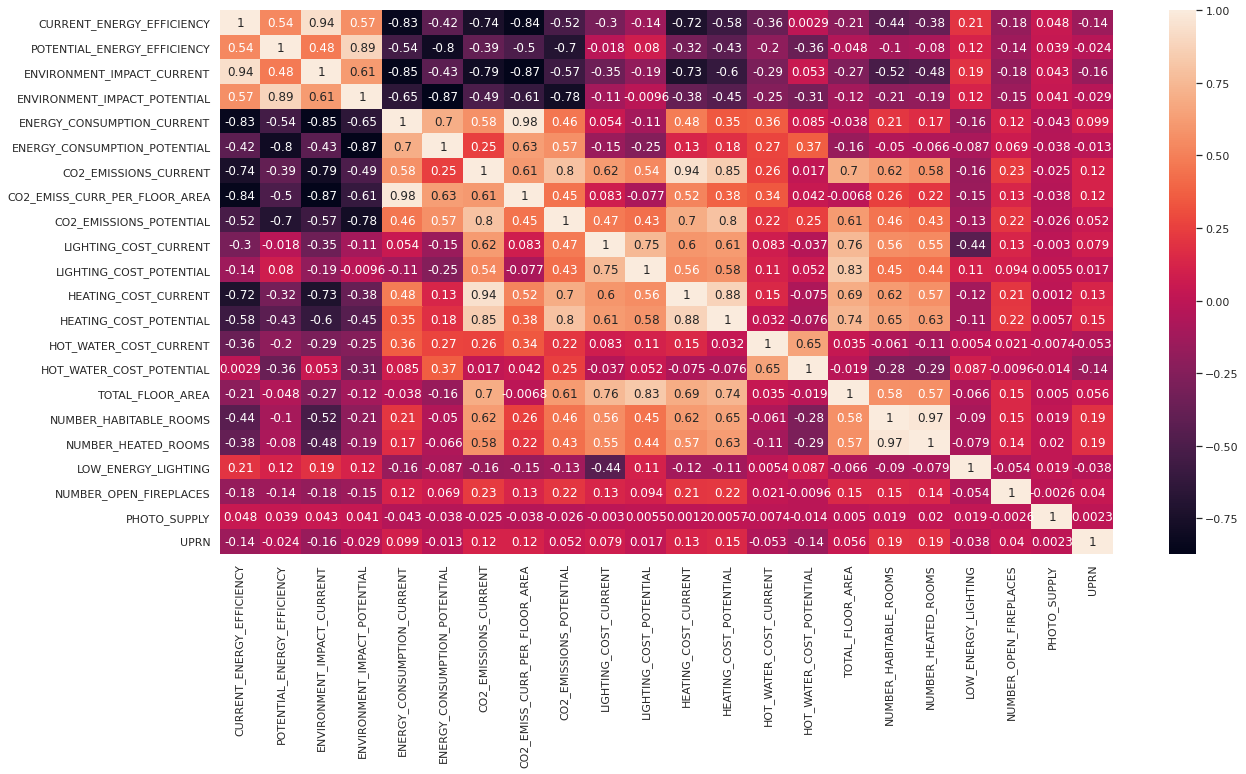

In [39]:
sns.heatmap(corelation, xticklabels=corelation.columns, yticklabels=corelation.columns,annot=True)

In [40]:
corelation['CURRENT_ENERGY_EFFICIENCY'].sort_values(ascending=False)

CURRENT_ENERGY_EFFICIENCY        1.000000
ENVIRONMENT_IMPACT_CURRENT       0.937248
ENVIRONMENT_IMPACT_POTENTIAL     0.568271
POTENTIAL_ENERGY_EFFICIENCY      0.535749
LOW_ENERGY_LIGHTING              0.209958
PHOTO_SUPPLY                     0.047680
HOT_WATER_COST_POTENTIAL         0.002912
LIGHTING_COST_POTENTIAL         -0.136532
UPRN                            -0.144275
NUMBER_OPEN_FIREPLACES          -0.176506
TOTAL_FLOOR_AREA                -0.209804
LIGHTING_COST_CURRENT           -0.299653
HOT_WATER_COST_CURRENT          -0.362499
NUMBER_HEATED_ROOMS             -0.382691
ENERGY_CONSUMPTION_POTENTIAL    -0.419572
NUMBER_HABITABLE_ROOMS          -0.439537
CO2_EMISSIONS_POTENTIAL         -0.520307
HEATING_COST_POTENTIAL          -0.577706
HEATING_COST_CURRENT            -0.722308
CO2_EMISSIONS_CURRENT           -0.742967
ENERGY_CONSUMPTION_CURRENT      -0.829964
CO2_EMISS_CURR_PER_FLOOR_AREA   -0.844444
Name: CURRENT_ENERGY_EFFICIENCY, dtype: float64

<AxesSubplot:xlabel='TOTAL_FLOOR_AREA', ylabel='BUILT_FORM'>

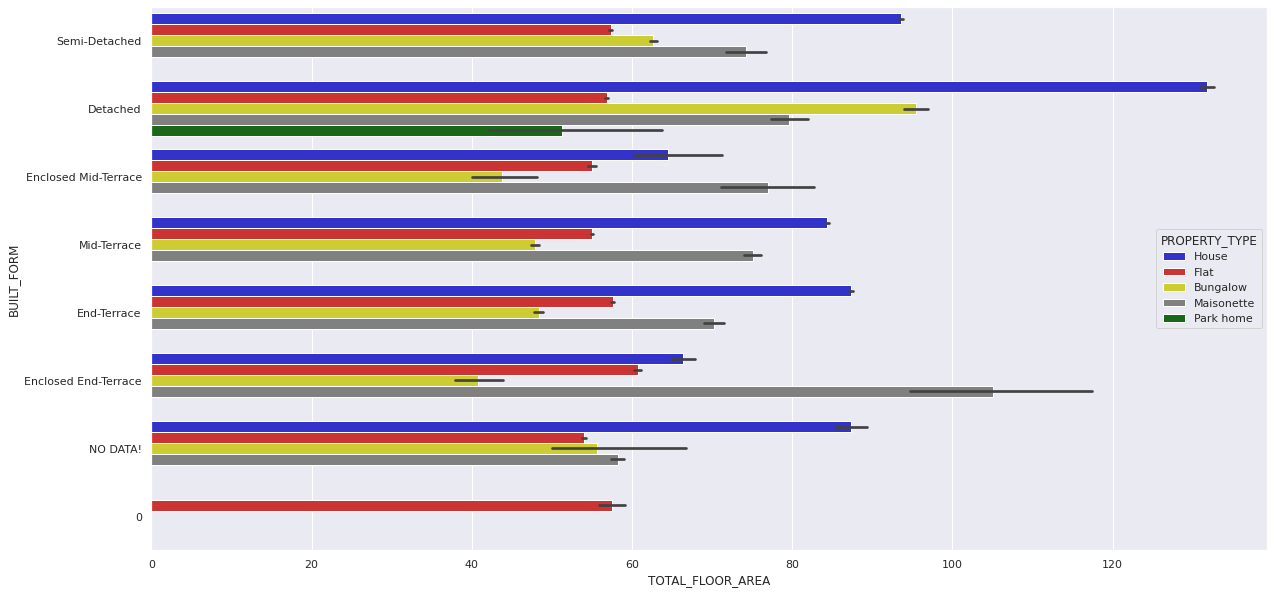

In [41]:
sns.barplot(data=pv, x="TOTAL_FLOOR_AREA", y="BUILT_FORM",hue="PROPERTY_TYPE",palette=['blue', 'red', 'yellow', 'grey','green'], saturation=0.6)

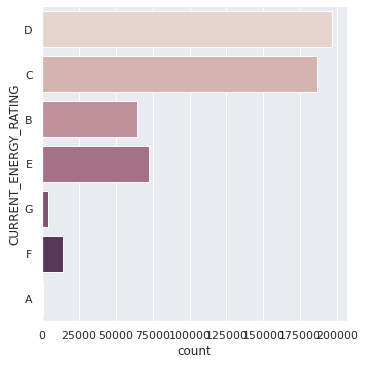

In [42]:
sns.catplot(y="CURRENT_ENERGY_RATING", kind="count", palette="ch:.10", data=pv)

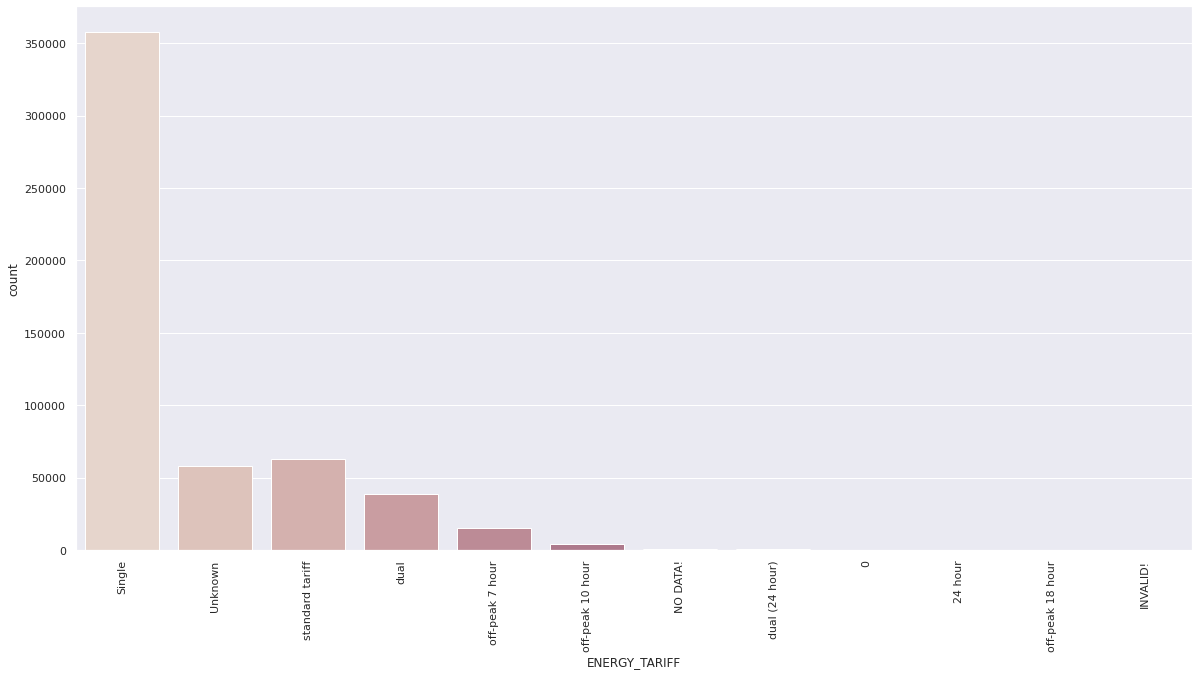

In [43]:
g=sns.countplot(x="ENERGY_TARIFF", palette="ch:.10", data=pv)
g.set_xticklabels(g.get_xticklabels(),rotation=90);


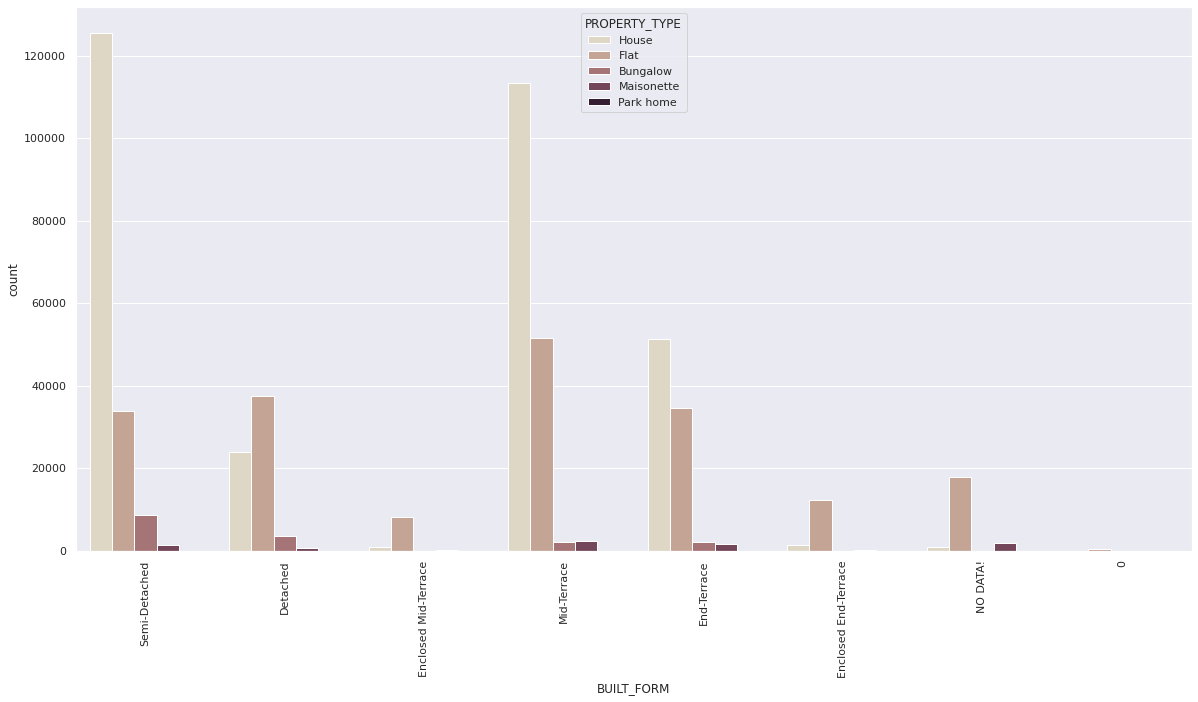

In [44]:
b=sns.countplot(x="BUILT_FORM", hue='PROPERTY_TYPE',palette="ch:.30", data=pv)
b.set_xticklabels(b.get_xticklabels(),rotation=90);


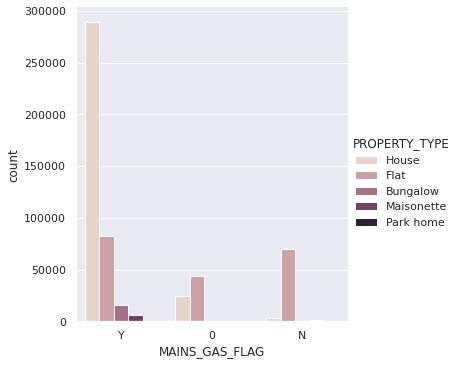

In [45]:
sns.catplot(x="MAINS_GAS_FLAG", kind="count",hue='PROPERTY_TYPE', palette="ch:.10", data=pv)

# Bi variate analysis

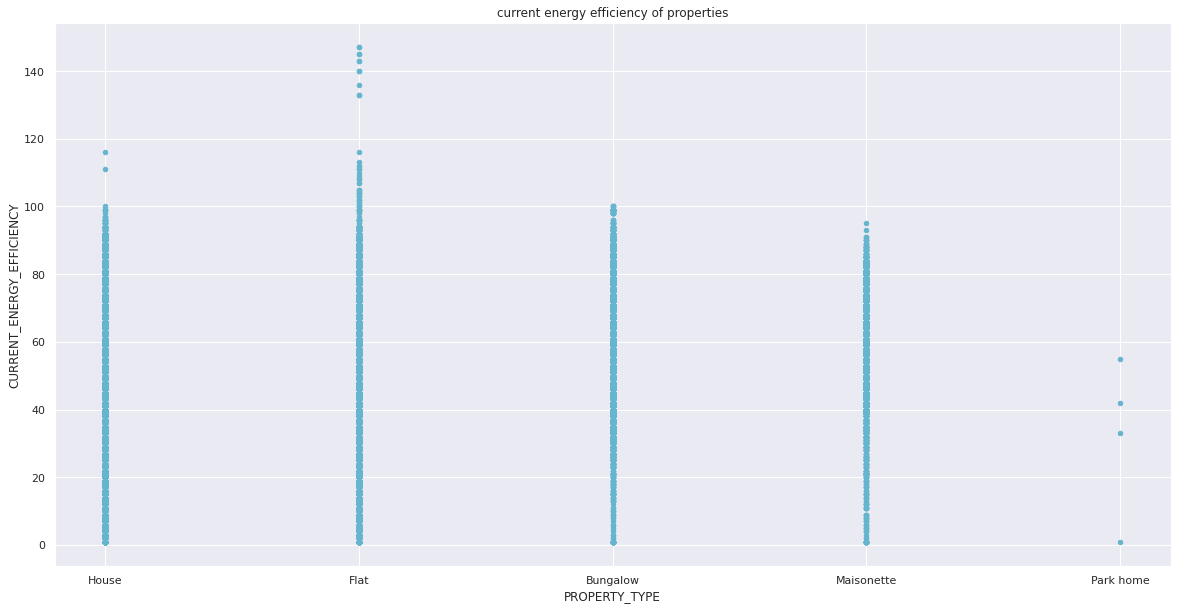

In [46]:
pv.plot.scatter(x='PROPERTY_TYPE',y='CURRENT_ENERGY_EFFICIENCY',color='c', title='current energy efficiency of properties');

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='POTENTIAL_ENERGY_EFFICIENCY', ylabel='Density'>

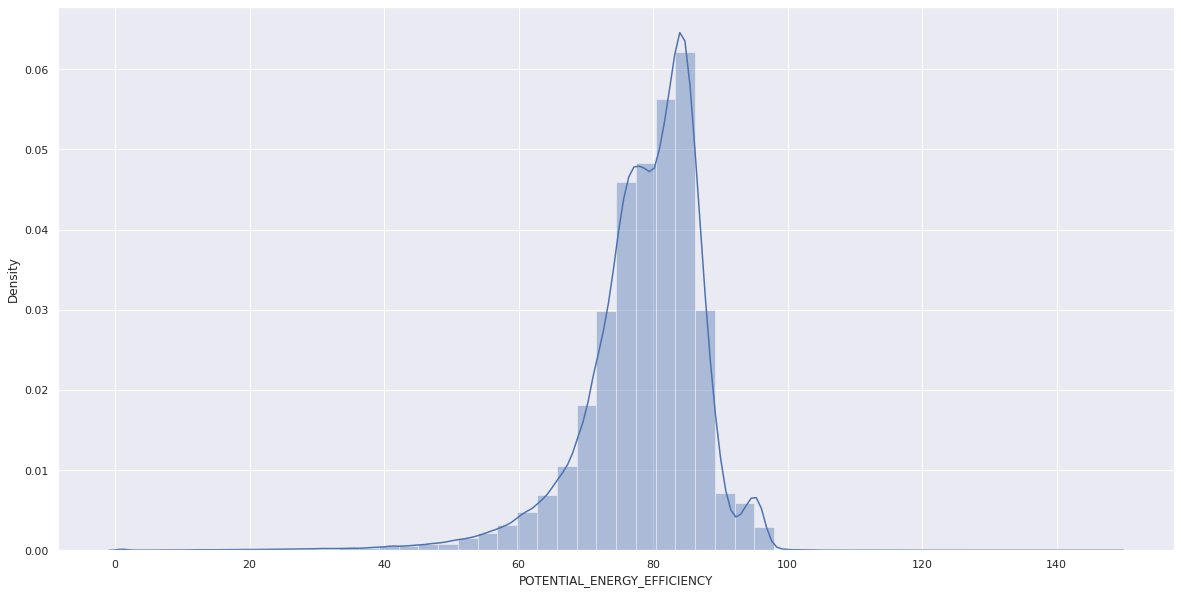

In [47]:
sns.distplot(pv['POTENTIAL_ENERGY_EFFICIENCY'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ENVIRONMENT_IMPACT_CURRENT', ylabel='Density'>

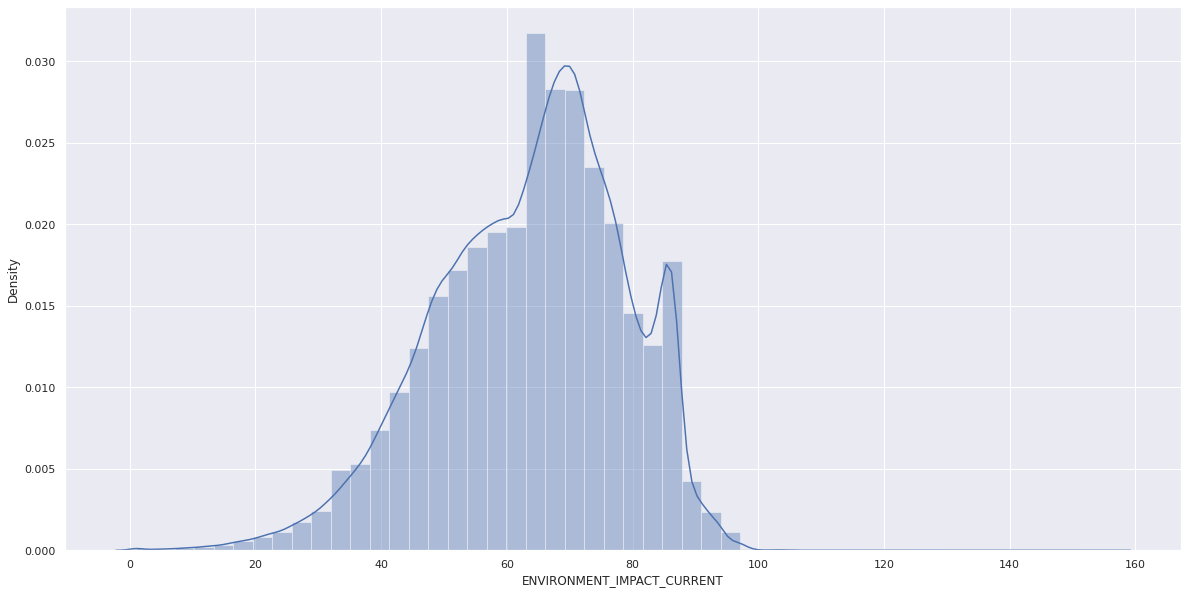

In [48]:
sns.distplot(pv['ENVIRONMENT_IMPACT_CURRENT'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='CO2_EMISSIONS_POTENTIAL', ylabel='Density'>

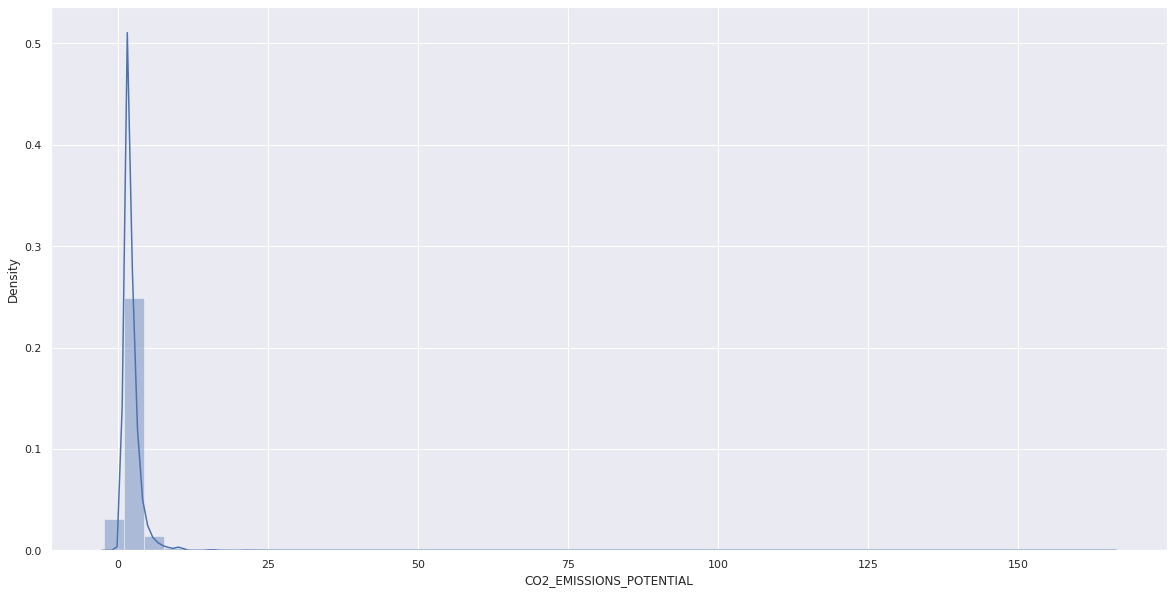

In [49]:
sns.distplot(pv['CO2_EMISSIONS_POTENTIAL'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ENVIRONMENT_IMPACT_CURRENT'>

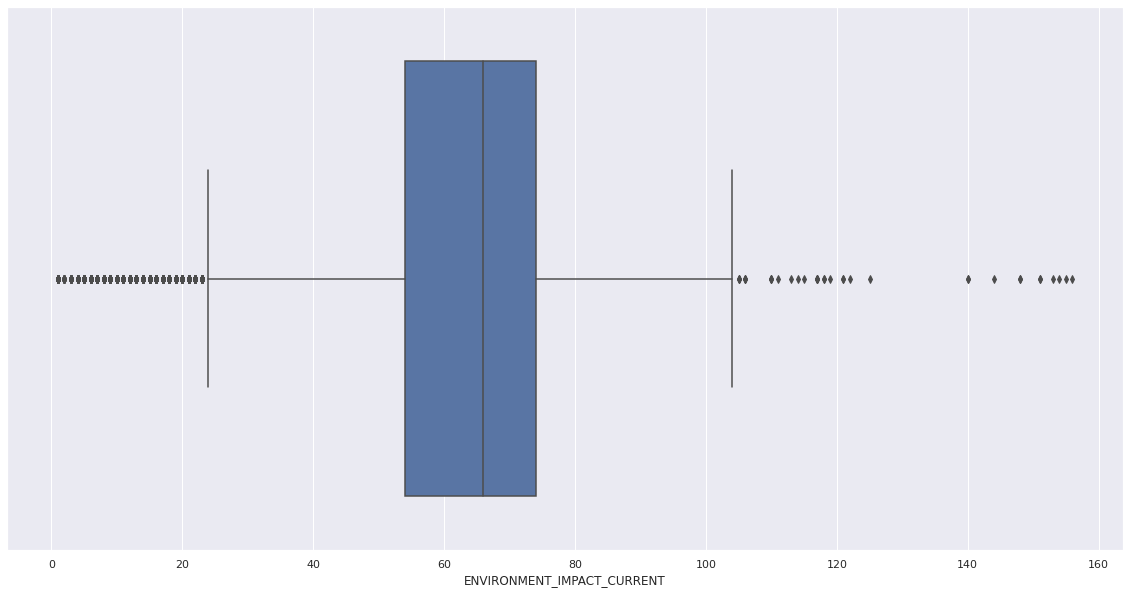

In [50]:
sns.boxplot('ENVIRONMENT_IMPACT_CURRENT',data=pv)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NUMBER_HABITABLE_ROOMS', ylabel='HEATING_COST_POTENTIAL'>

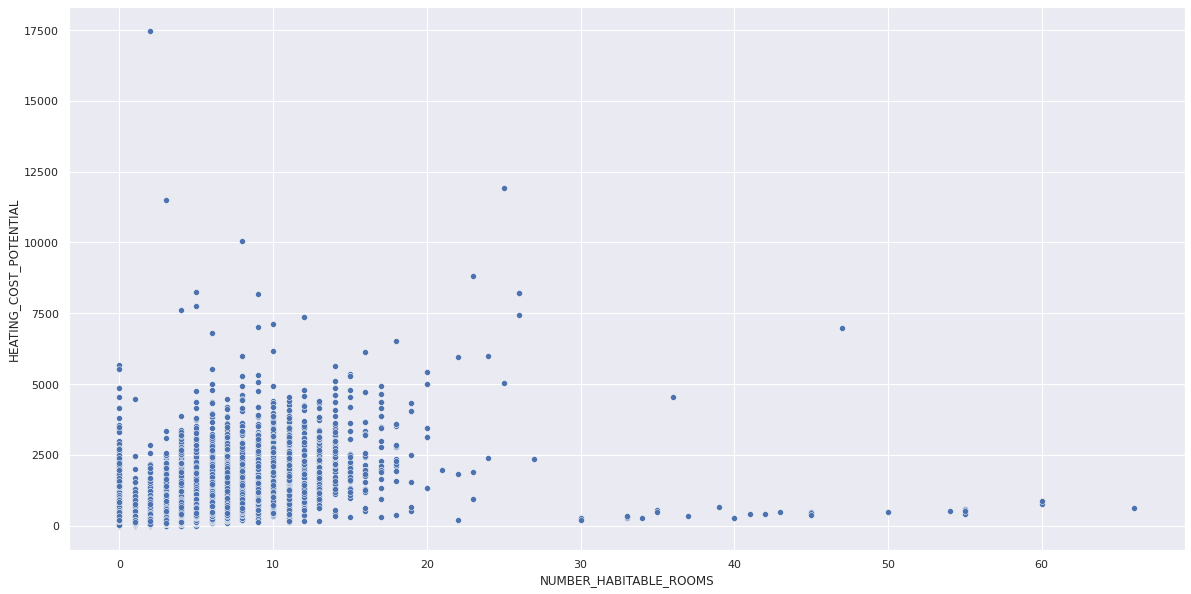

In [51]:
sns.scatterplot(pv['NUMBER_HABITABLE_ROOMS'],pv['HEATING_COST_POTENTIAL'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='PROPERTY_TYPE', ylabel='TRANSACTION_TYPE'>

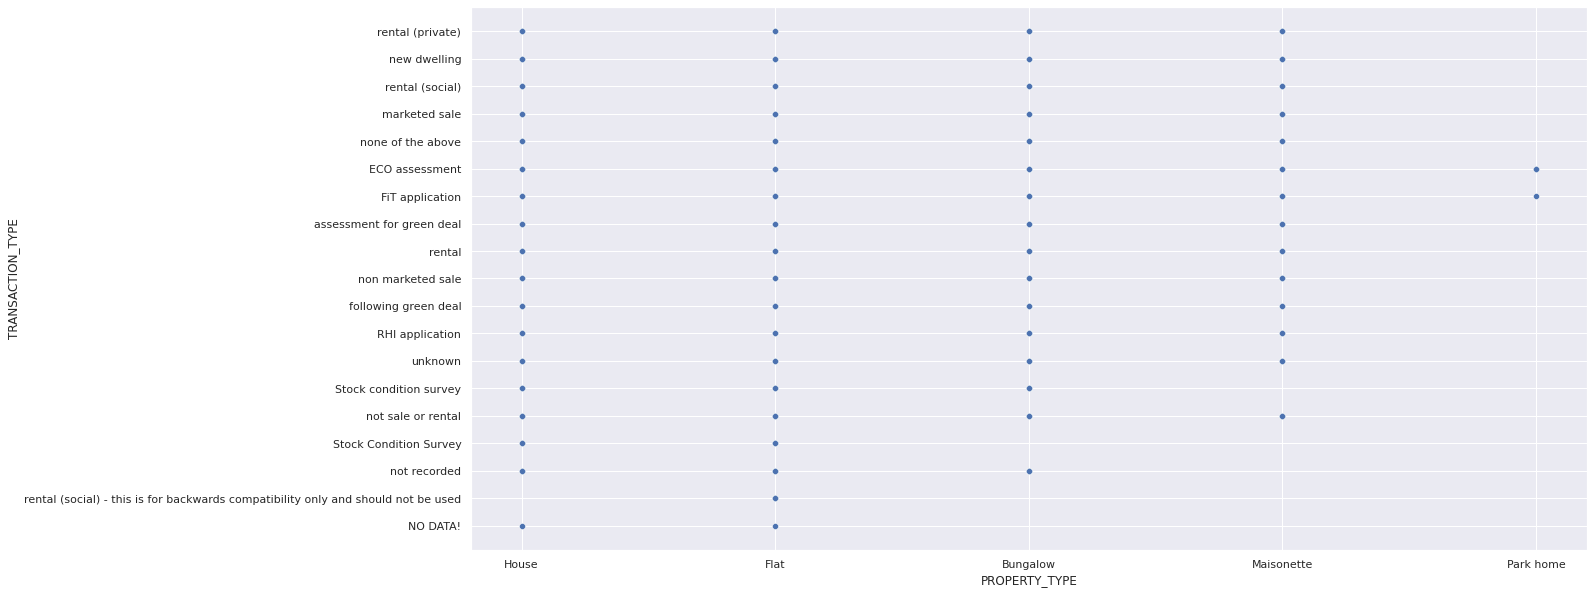

In [52]:
sns.scatterplot(pv['PROPERTY_TYPE'],pv['TRANSACTION_TYPE'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='CO2_EMISSIONS_POTENTIAL', ylabel='PROPERTY_TYPE'>

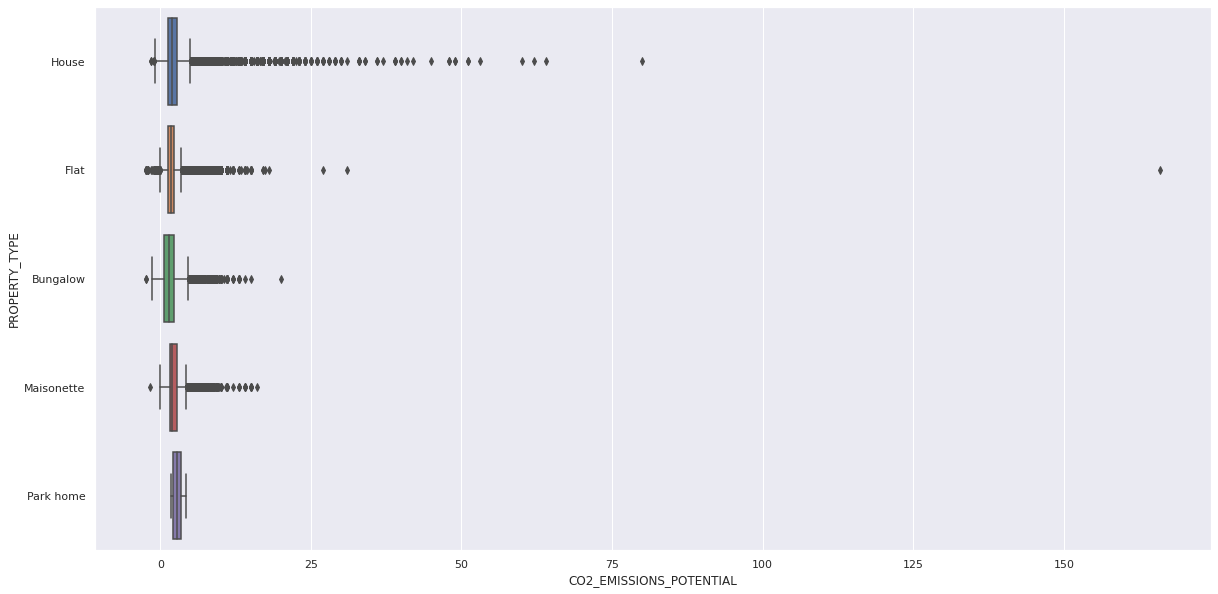

In [53]:
sns.boxplot('CO2_EMISSIONS_POTENTIAL','PROPERTY_TYPE',data=pv)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ENVIRONMENT_IMPACT_CURRENT', ylabel='PROPERTY_TYPE'>

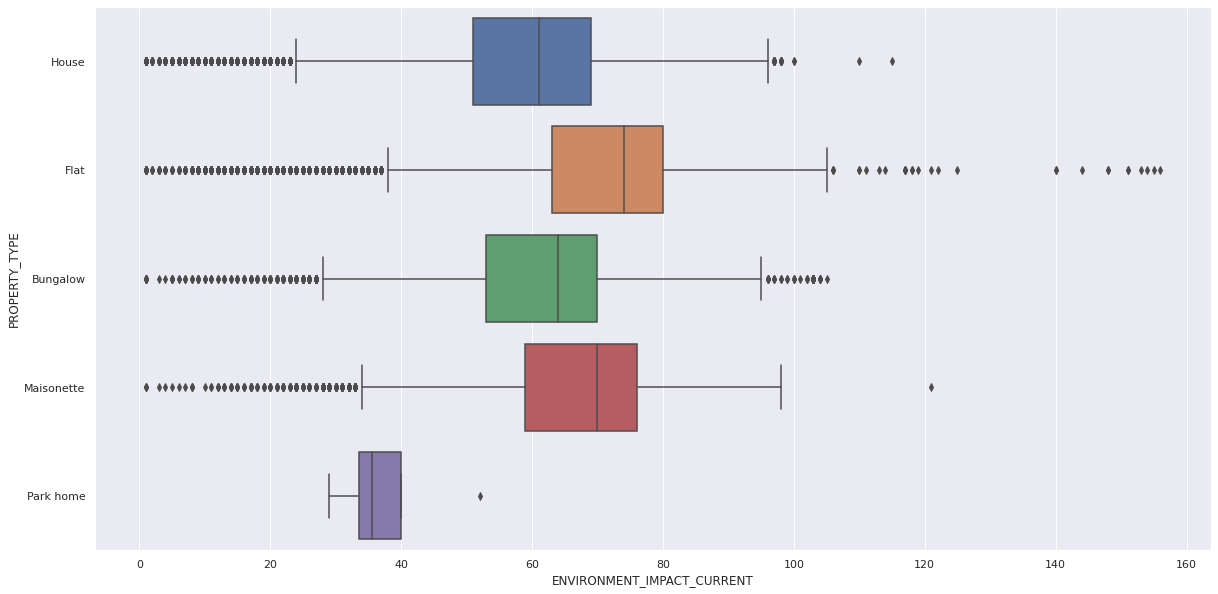

In [54]:
sns.boxplot('ENVIRONMENT_IMPACT_CURRENT','PROPERTY_TYPE',data=pv)

<AxesSubplot:xlabel='NUMBER_OPEN_FIREPLACES', ylabel='CURRENT_ENERGY_EFFICIENCY'>

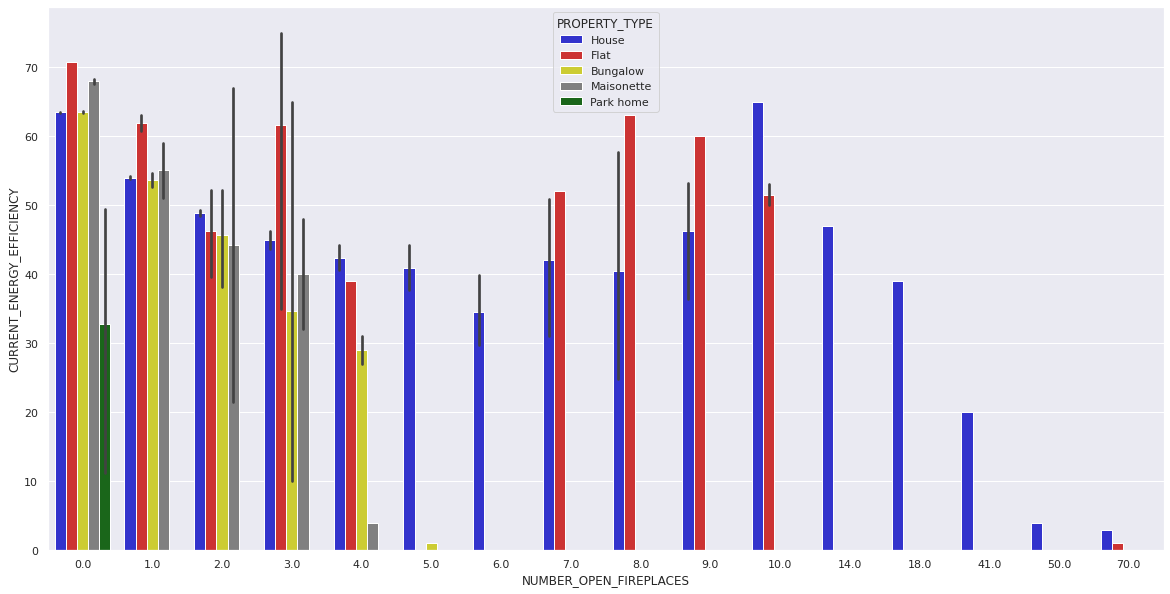

In [55]:
sns.barplot(data=pv, x="NUMBER_OPEN_FIREPLACES", y="CURRENT_ENERGY_EFFICIENCY",hue="PROPERTY_TYPE",palette=['blue', 'red', 'yellow', 'grey','green'], saturation=0.6)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='CO2_EMISSIONS_CURRENT', ylabel='BUILT_FORM'>

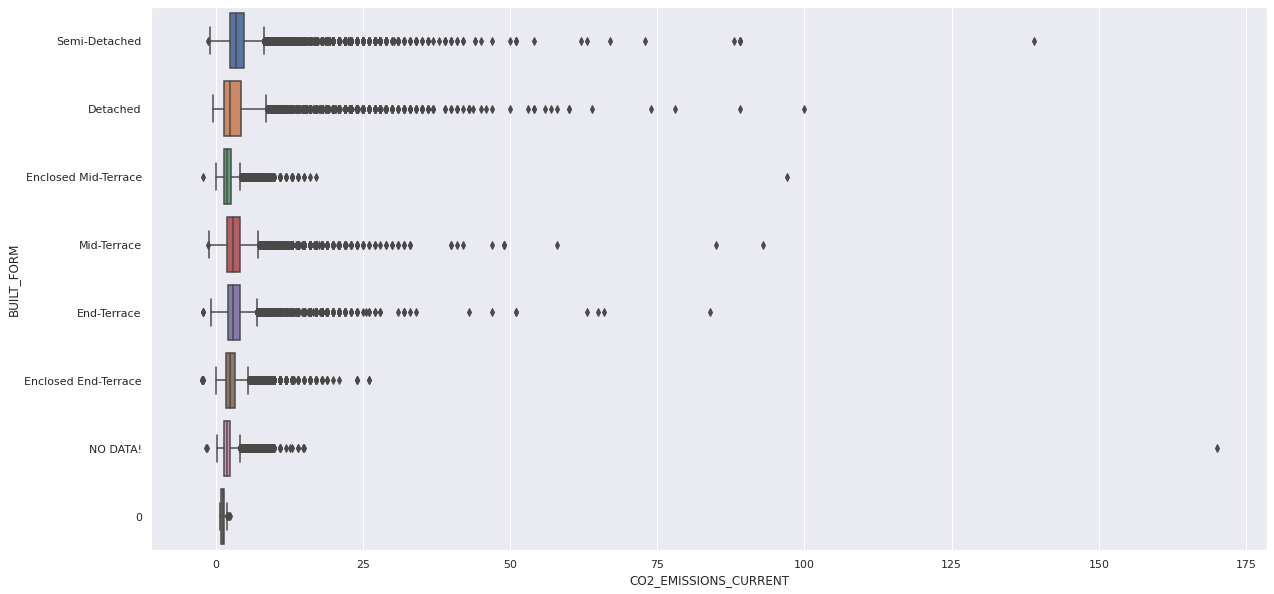

In [56]:
sns.boxplot('CO2_EMISSIONS_CURRENT','BUILT_FORM',data=pv)

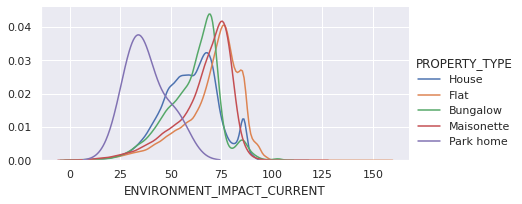

In [57]:
from sklearn.neighbors import KernelDensity
def kde_plot(feature):
    grid = sns.FacetGrid(pv, hue="PROPERTY_TYPE",aspect=2)
    grid.map(sns.kdeplot, feature)
    grid.add_legend()
kde_plot('ENVIRONMENT_IMPACT_CURRENT')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


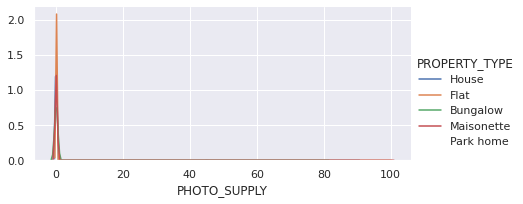

In [58]:
kde_plot('PHOTO_SUPPLY')

In [59]:
pv.drop(['UPRN'],axis=1,inplace=True)

# catogorical data

In [60]:
catogorical_data=pv.select_dtypes(exclude=[np.number])

In [61]:
catogorical_data.head()

,CURRENT_ENERGY_RATING,POTENTIAL_ENERGY_RATING,PROPERTY_TYPE,BUILT_FORM,INSPECTION_DATE,LODGEMENT_DATE,TRANSACTION_TYPE,ENERGY_TARIFF,MAINS_GAS_FLAG,FLOOR_LEVEL,SOLAR_WATER_HEATING_FLAG,ROOF_DESCRIPTION,solar_suitable
0,D,B,House,Semi-Detached,2020-06-09,2020-06-09,rental (private),Single,Y,NODATA!,N,"Pitched, no insulation",high
1,D,D,House,Semi-Detached,2011-11-21,2011-11-22,rental (private),Single,Y,NODATA!,0,"Pitched, 150 mm loft insulation",high
2,C,B,House,Semi-Detached,2014-06-25,2014-06-25,rental (private),Single,Y,NODATA!,0,"Pitched, 250mm loft insulation",high
3,D,B,House,Semi-Detached,2012-08-20,2012-08-21,rental (private),Unknown,Y,NODATA!,0,"Pitched, 150 mm loft insulation",high
4,B,A,House,Detached,2020-03-26,2020-03-26,new dwelling,standard tariff,0,NO DATA!,0,Average thermal transmittance 0.11 W/m²K,high


# Numerical data

In [62]:
numerical_data=pv.select_dtypes(include=[np.number])

In [63]:
numerical_data.head()

,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,CO2_EMISSIONS_POTENTIAL,LIGHTING_COST_CURRENT,...,HEATING_COST_CURRENT,HEATING_COST_POTENTIAL,HOT_WATER_COST_CURRENT,HOT_WATER_COST_POTENTIAL,TOTAL_FLOOR_AREA,NUMBER_HABITABLE_ROOMS,NUMBER_HEATED_ROOMS,LOW_ENERGY_LIGHTING,NUMBER_OPEN_FIREPLACES,PHOTO_SUPPLY
0,60,82,51,78,262,115.0,6.1,46.0,2.7,142.0,...,1047.0,644.0,107.0,76.0,132.0,6.0,6.0,40.0,0.0,0.0
1,55,64,52,63,342,260.0,3.6,66.0,2.7,62.0,...,546.0,461.0,139.0,100.0,54.2,4.0,4.0,0.0,0.0,0.0
2,74,84,73,83,145,86.0,3.0,28.0,1.9,87.0,...,554.0,515.0,96.0,96.0,110.0,7.0,7.0,59.0,0.0,0.0
3,68,86,69,87,223,96.0,2.4,43.0,1.1,49.0,...,426.0,398.0,76.0,54.0,56.0,3.0,3.0,50.0,0.0,0.0
4,82,93,83,94,100,32.0,1.6,18.0,0.5,68.0,...,271.0,271.0,77.0,48.0,89.0,0.0,0.0,100.0,0.0,0.0


# catogorical data label encoding

In [64]:
for col in catogorical_data.columns:
    print(col,':',len(catogorical_data[col].unique()),'labels')

CURRENT_ENERGY_RATING : 7 labels
POTENTIAL_ENERGY_RATING : 7 labels
PROPERTY_TYPE : 5 labels
BUILT_FORM : 8 labels
INSPECTION_DATE : 4793 labels
LODGEMENT_DATE : 4730 labels
TRANSACTION_TYPE : 19 labels
ENERGY_TARIFF : 12 labels
MAINS_GAS_FLAG : 3 labels
FLOOR_LEVEL : 57 labels
SOLAR_WATER_HEATING_FLAG : 3 labels
ROOF_DESCRIPTION : 295 labels
solar_suitable : 2 labels


In [65]:
catogorical_data.drop(['CURRENT_ENERGY_RATING','POTENTIAL_ENERGY_RATING','INSPECTION_DATE','LODGEMENT_DATE','FLOOR_LEVEL'],axis=1,inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
catogorical_data.head()

,PROPERTY_TYPE,BUILT_FORM,TRANSACTION_TYPE,ENERGY_TARIFF,MAINS_GAS_FLAG,SOLAR_WATER_HEATING_FLAG,ROOF_DESCRIPTION,solar_suitable
0,House,Semi-Detached,rental (private),Single,Y,N,"Pitched, no insulation",high
1,House,Semi-Detached,rental (private),Single,Y,0,"Pitched, 150 mm loft insulation",high
2,House,Semi-Detached,rental (private),Single,Y,0,"Pitched, 250mm loft insulation",high
3,House,Semi-Detached,rental (private),Unknown,Y,0,"Pitched, 150 mm loft insulation",high
4,House,Detached,new dwelling,standard tariff,0,0,Average thermal transmittance 0.11 W/m²K,high


<AxesSubplot:ylabel='solar_suitable'>

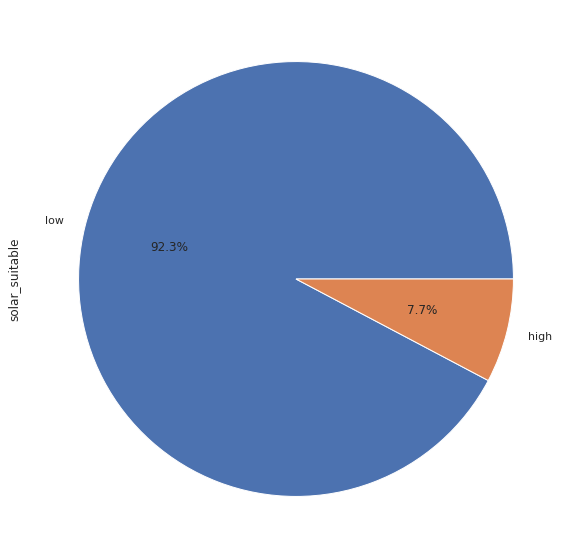

In [67]:
catogorical_data['solar_suitable'].value_counts().plot.pie(autopct="%1.1f%%")

In [68]:
solar_encode = pd.get_dummies(catogorical_data['solar_suitable'],drop_first=False)

In [69]:
solar_encode.head()

,high,low
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [70]:
Y=solar_encode['high']

In [71]:
Y.head()

0    1
1    1
2    1
3    1
4    1
Name: high, dtype: uint8

In [72]:
property_encode = pd.get_dummies(catogorical_data['PROPERTY_TYPE'],drop_first=True)

In [73]:
built_encode= pd.get_dummies(catogorical_data['BUILT_FORM'],drop_first=True)

In [74]:
transaction_encode=pd.get_dummies(catogorical_data['TRANSACTION_TYPE'],drop_first=True)

In [75]:
energy_encode= pd.get_dummies(catogorical_data['ENERGY_TARIFF'],drop_first=True)

In [76]:
main_gas_encode=pd.get_dummies(catogorical_data['MAINS_GAS_FLAG'],drop_first=True)

In [77]:
solar_water_encode=pd.get_dummies(catogorical_data['SOLAR_WATER_HEATING_FLAG'],drop_first=True)

In [78]:
roof_encoded = pd.get_dummies(catogorical_data['ROOF_DESCRIPTION'],drop_first=True)

In [79]:
property_encode.head()

,Flat,House,Maisonette,Park home
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0


In [80]:
pd.concat([property_encode,built_encode,transaction_encode,energy_encode,main_gas_encode,solar_water_encode,roof_encoded],axis=1)

,Flat,House,Maisonette,Park home,Detached,Enclosed End-Terrace,Enclosed Mid-Terrace,End-Terrace,Mid-Terrace,NO DATA!,...,"Roof room(s), insulated (assumed)","Roof room(s), limited insulation","Roof room(s), limited insulation (assumed)","Roof room(s), no insulation","Roof room(s), no insulation (assumed)","Roof room(s), no insulation(assumed)","Roof room(s), thatched",SAP05:Roof,Thatched,"Thatched, with additional insulation"
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537917,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537918,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
537919,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
537920,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
join=pd.concat([numerical_data,property_encode,built_encode,transaction_encode,
             energy_encode,main_gas_encode,solar_water_encode,roof_encoded],axis=1)

In [82]:
join.to_csv('catogorical_encoded_features.csv')

In [83]:
join.head()

,CURRENT_ENERGY_EFFICIENCY,POTENTIAL_ENERGY_EFFICIENCY,ENVIRONMENT_IMPACT_CURRENT,ENVIRONMENT_IMPACT_POTENTIAL,ENERGY_CONSUMPTION_CURRENT,ENERGY_CONSUMPTION_POTENTIAL,CO2_EMISSIONS_CURRENT,CO2_EMISS_CURR_PER_FLOOR_AREA,CO2_EMISSIONS_POTENTIAL,LIGHTING_COST_CURRENT,...,"Roof room(s), insulated (assumed)","Roof room(s), limited insulation","Roof room(s), limited insulation (assumed)","Roof room(s), no insulation","Roof room(s), no insulation (assumed)","Roof room(s), no insulation(assumed)","Roof room(s), thatched",SAP05:Roof,Thatched,"Thatched, with additional insulation"
0,60,82,51,78,262,115.0,6.1,46.0,2.7,142.0,...,0,0,0,0,0,0,0,0,0,0
1,55,64,52,63,342,260.0,3.6,66.0,2.7,62.0,...,0,0,0,0,0,0,0,0,0,0
2,74,84,73,83,145,86.0,3.0,28.0,1.9,87.0,...,0,0,0,0,0,0,0,0,0,0
3,68,86,69,87,223,96.0,2.4,43.0,1.1,49.0,...,0,0,0,0,0,0,0,0,0,0
4,82,93,83,94,100,32.0,1.6,18.0,0.5,68.0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
#join['CO2_EMISS_CURR_PER_FLOOR_AREA'].value_counts().plot.pie(autopct="%1.1f%%")

In [85]:
X=join

# classifiers
Regression models

In [86]:
#linear regression model

from sklearn import linear_model
from sklearn.model_selection import train_test_split
X_train, X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state= 40)
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
predicted = regr.predict(X_test)

In [87]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(430337, 359)
(107585, 359)
(430337,)
(107585,)


In [88]:
print (regr.intercept_)

-0.12330481627634418


In [89]:
print(regr.coef_)

[ 4.59548259e-03 -2.53950129e-03 -1.22026825e-03  7.76608968e-04
  5.31468605e-05 -3.28099274e-05 -2.54399850e-02  1.02932868e-03
  1.30280848e-02  1.07389479e-04  4.05239882e-04  7.65960348e-05
 -9.01134324e-05  1.07212493e-04 -4.17831613e-04  6.86656151e-04
 -8.07110355e-05 -1.16318044e-02  9.06689920e-05 -3.09525719e-03
  3.25575788e-04 -1.61525598e-01  3.50746905e-02 -1.11775042e-01
 -2.08830270e-01  4.70878489e-02  4.16784622e-03 -2.39485199e-02
  5.17065887e-02 -7.56351350e-02 -2.39869945e-02  6.90435089e-02
  5.28385766e-01  4.30039804e-02  4.28927220e-01  9.70969239e-02
 -3.88440197e-03  2.98328022e-01  4.42542544e-01 -2.65875597e-02
  1.05141457e-01 -1.74732045e-02 -3.33049553e-03 -3.59926989e-02
 -1.97660131e-02  1.33356557e-02  2.00463324e-01  8.85283710e-03
 -2.21272199e-02  3.36778733e-02 -3.62240345e-02  8.71105265e-02
 -3.50712066e-02 -2.25262756e-02 -3.16689497e-02 -3.25672530e-02
 -7.85294251e-02  1.09841551e-02 -5.53810371e-02 -3.45185757e-02
  3.14700449e-02  8.12294

In [90]:
from sklearn.metrics import r2_score
Y_pred=regr.predict(X_test)
score=r2_score(Y_test,Y_pred)
print(score)

0.4657021526090305


In [91]:
Y_pred

array([-0.14134834, -0.06125752,  0.37984203, ...,  0.28349535,
        0.31895822, -0.07249951])

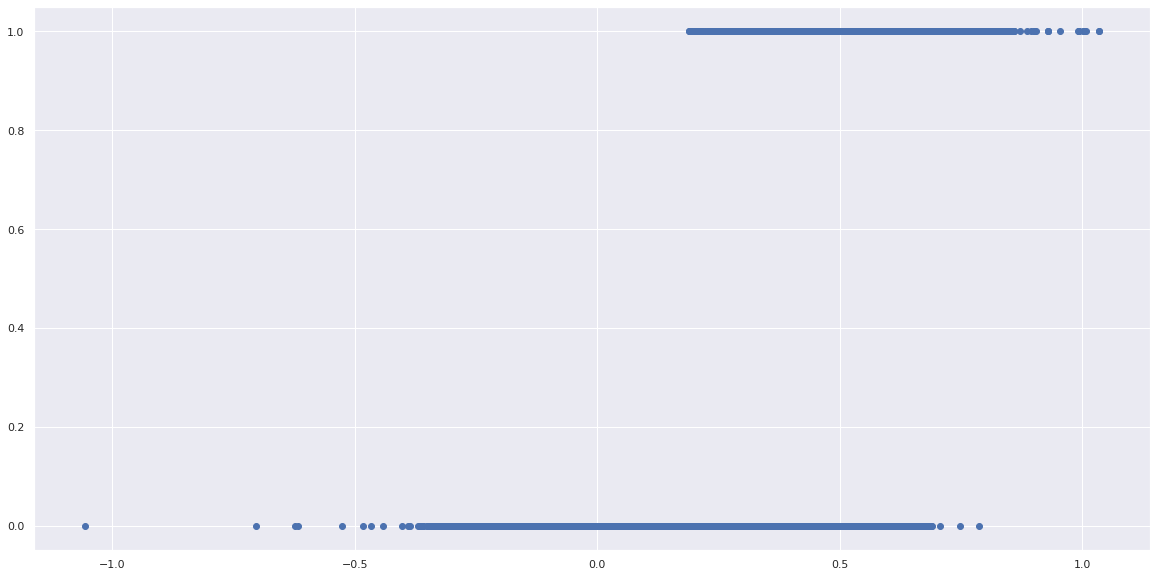

In [92]:
plt.scatter(Y_pred,Y_test)
plt.show()

In [93]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(Y_test,Y_pred))

0.12846388916671286


# logistic regression

In [94]:
#logistic regression

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, Y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, Y_test)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of Logistic regression classifier on training set: 0.94
Accuracy of Logistic regression classifier on test set: 0.94


<AxesSubplot:ylabel='high'>

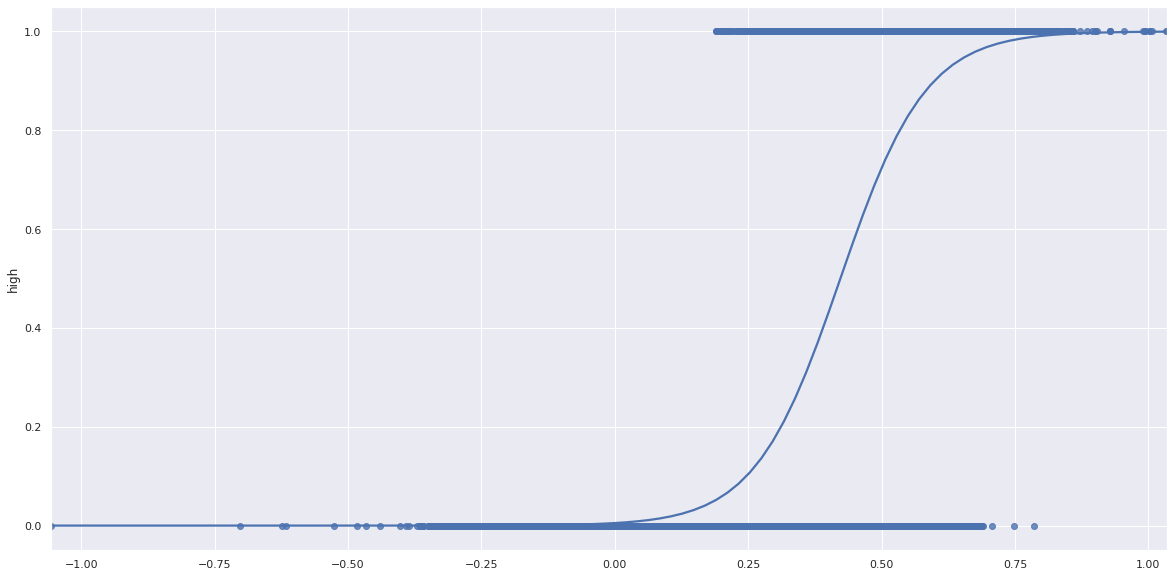

In [95]:
sns.regplot(x=Y_pred, y=Y_test, data=X, logistic=True, ci=None)

In [96]:
#decision tree model
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, Y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, Y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, Y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 1.00


# Gaussian naive bayes

In [97]:
#Gaussian naive bayes

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, Y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, Y_test)))

Accuracy of GNB classifier on training set: 0.98
Accuracy of GNB classifier on test set: 0.98


In [98]:
# decision tree 'entrophy'
# helps in measures the purity of split( % +ve class/%-ve class)


model =DecisionTreeClassifier(criterion ='entropy', max_depth = 4)
model.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [99]:
pip install termcolor

  Preparing metadata (setup.py) ... done
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=35bd64f48618aa3d4bfb6ee1a2f43800ce95b941a001b033d7d09f8f40ea26ec
  Stored in directory: /home/ec2-user/.cache/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc
Successfully built termcolor
Note: you may need to restart the kernel to use updated packages.


In [100]:
from termcolor import colored as cl
from sklearn.metrics import accuracy_score
pred_model = model.predict(X_test)
print(cl('Accuracy of the model is {:.0%}'.format(accuracy_score(Y_test,pred_model)),attrs=['bold']))

Accuracy of the model is 97%


# decision tree plot

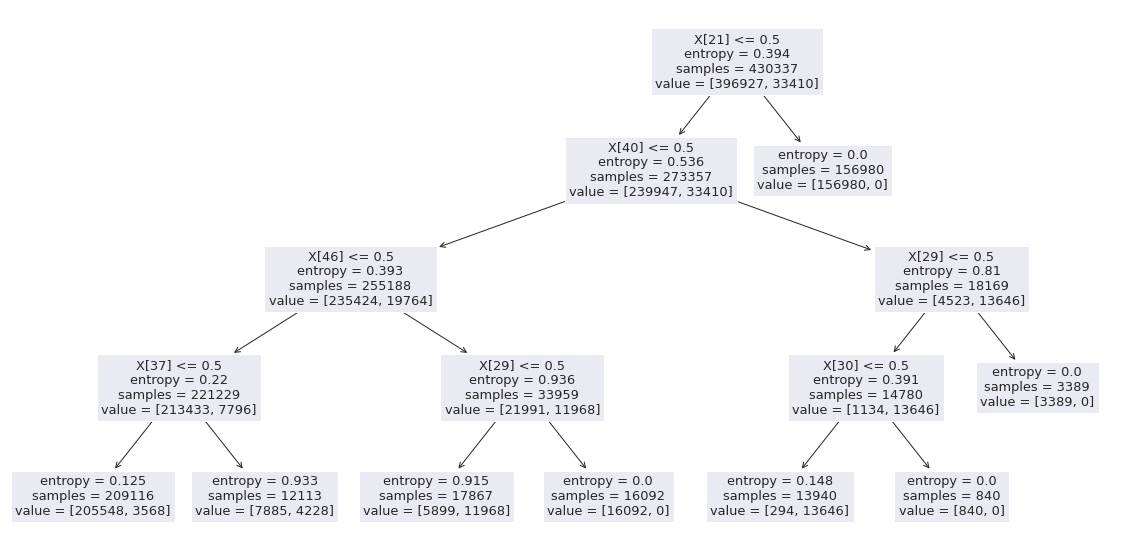

In [101]:
from sklearn.tree import plot_tree
from sklearn import tree
tree.plot_tree(model)
plt.savefig('tree_visualization.png')

# ROC 

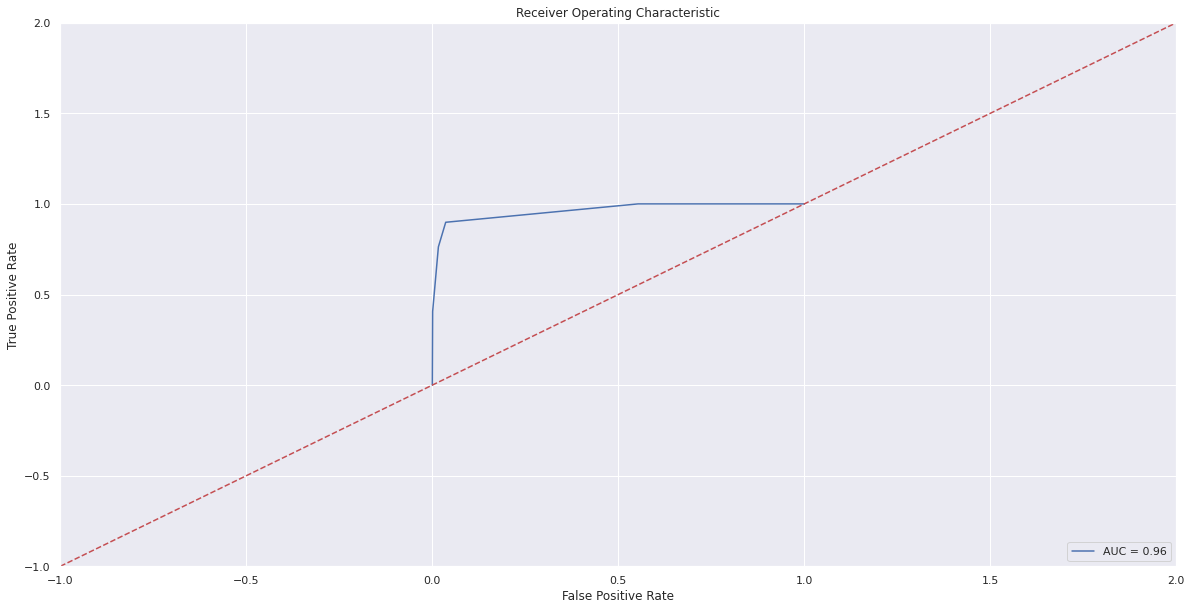

In [102]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([-1, 2], [-1, 2],'r--')
plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [103]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=",", fmt="%g")
    return csv.getvalue().decode().rstrip()

In [104]:
# mean absolute error

test_mae_linear = np.mean(np.abs(Y_test- Y_pred))
test_mae_baseline = np.mean(
    np.abs(Y_test - np.median(Y_train))
)  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 0.076
Test MAE Linear: 0.128


# Random forest

In [105]:
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor(n_estimators = 100, random_state=0)
rf.fit(X_train,Y_train)

RandomForestRegressor(random_state=0)

In [106]:
Y_pred=rf.predict(X_test)

In [107]:
rf.estimators_

[DecisionTreeRegressor(max_features='auto', random_state=209652396),
 DecisionTreeRegressor(max_features='auto', random_state=398764591),
 DecisionTreeRegressor(max_features='auto', random_state=924231285),
 DecisionTreeRegressor(max_features='auto', random_state=1478610112),
 DecisionTreeRegressor(max_features='auto', random_state=441365315),
 DecisionTreeRegressor(max_features='auto', random_state=1537364731),
 DecisionTreeRegressor(max_features='auto', random_state=192771779),
 DecisionTreeRegressor(max_features='auto', random_state=1491434855),
 DecisionTreeRegressor(max_features='auto', random_state=1819583497),
 DecisionTreeRegressor(max_features='auto', random_state=530702035),
 DecisionTreeRegressor(max_features='auto', random_state=626610453),
 DecisionTreeRegressor(max_features='auto', random_state=1650906866),
 DecisionTreeRegressor(max_features='auto', random_state=1879422756),
 DecisionTreeRegressor(max_features='auto', random_state=1277901399),
 DecisionTreeRegressor(max_

In [108]:
len(rf.estimators_)

100

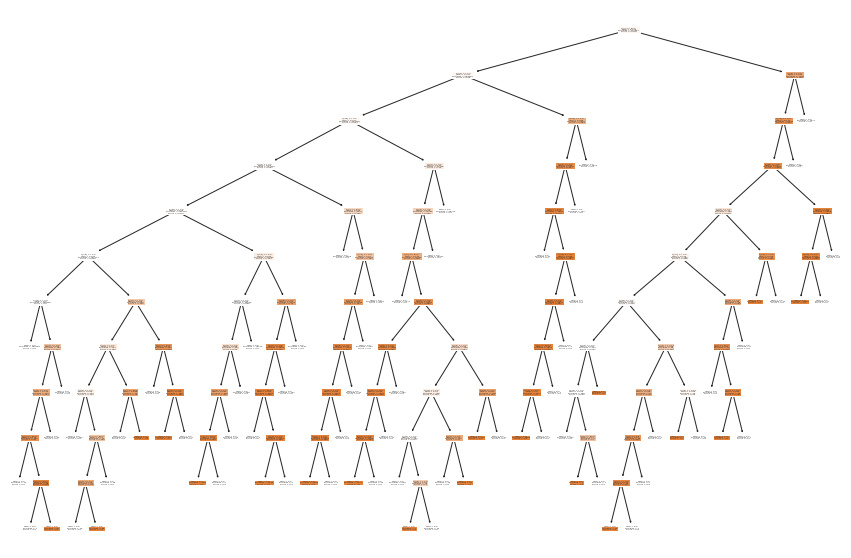

In [109]:
plt.figure(figsize=(15,10))
tree.plot_tree(rf.estimators_[2],filled=True)
plt.savefig('Random_Forest_tree.png')

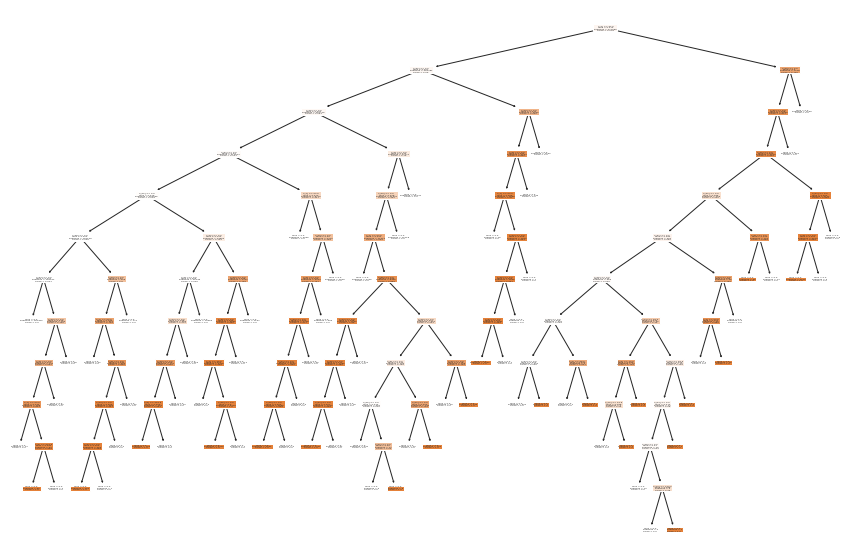

In [110]:
plt.figure(figsize=(15,10))
for i in range(len(rf.estimators_)):
    tree.plot_tree(rf.estimators_[i],filled=True)

In [111]:
for i in range(len(rf.estimators_)):
    print(tree.export_text(rf.estimators_[i]))

|--- feature_1 <= 92.50
|   |--- feature_32 <= 0.50
|   |   |--- feature_46 <= 0.50
|   |   |   |--- feature_37 <= 0.50
|   |   |   |   |--- feature_40 <= 0.50
|   |   |   |   |   |--- feature_38 <= 0.50
|   |   |   |   |   |   |--- feature_34 <= 0.50
|   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |--- feature_34 >  0.50
|   |   |   |   |   |   |   |--- feature_29 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_21 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 54.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |   |--- feature_0 >  54.50
|   |   |   |   |   |   |   |   |   |   |--- feature_23 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [1.00]
|   |   |   |   |   |   |   |   |   |   |--- feature_23 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |--- feature_21 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [0.00]
|

|--- feature_1 <= 92.50
|   |--- feature_32 <= 0.50
|   |   |--- feature_46 <= 0.50
|   |   |   |--- feature_37 <= 0.50
|   |   |   |   |--- feature_40 <= 0.50
|   |   |   |   |   |--- feature_38 <= 0.50
|   |   |   |   |   |   |--- feature_34 <= 0.50
|   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |--- feature_34 >  0.50
|   |   |   |   |   |   |   |--- feature_29 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_61 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 54.50
|   |   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |   |--- feature_0 >  54.50
|   |   |   |   |   |   |   |   |   |   |--- feature_23 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- feature_23 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [0.00]
|   |   |   |   |   |   |   |   |--- feature_61 >  0.50
|   |   |   |   |   |   |   |   |   |--- f

In [112]:
#reading dataset of master dataset_manchester
#bucket='datascience-nurture/ManchesterData/MasterDataset_Manchester.csv'
#data_key='MasterDataset_Manchester.csv'
#data_location='s3://datascience-nurture/ManchesterData/MasterDataset_Manchester.csv'
#data=pd.read_csv(data_location)
#data.head()

In [113]:
#location=data[['pd_longitude','pd_latitude']]

In [114]:
#location.head()

In [115]:
#location.isnull().sum()

In [116]:
#visual=pd.concat([join,location],axis=1)

In [117]:
#visual.head()

In [118]:
#visual.to_csv('visual.csv')